In [755]:
import pickle
import warnings
warnings.filterwarnings('ignore')
import pandas as pd, os
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, StratifiedKFold
import sklearn.metrics
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import plot_tree
%matplotlib inline
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn import preprocessing
from sklearn.naive_bayes import GaussianNB
import operator
import copy
from sklearn.metrics import balanced_accuracy_score
from sklearn import svm
import impyute as impy
from xgboost import XGBClassifier
from xgboost import plot_tree
import xgboost as xgb
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import shap, glob
from mlxtend.evaluate import bootstrap
from sklearn.metrics import roc_curve, roc_auc_score
from numpy import format_float_scientific
from imblearn.ensemble import BalancedRandomForestClassifier
import inspect
import datetime
from sklearn.base import ClassifierMixin, BaseEstimator
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import RandomState
from numpy.testing import assert_almost_equal
import pymc as pm
import pymc_experimental as pmx
from scipy.special import expit
import aesara
import aesara.tensor as T
from sklearn.metrics import roc_auc_score
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
import dask
from dask.diagnostics import ProgressBar
import tqdm
import xarray as xr
np.random.seed(42)

# Models and Convenience Functions

In [188]:
class BART(BaseEstimator, ClassifierMixin):
    def __init__(self, m=70, alpha=0.3, train_sample=100, test_sample=1000):
        self.m=m
        self.alpha=alpha
        self.train_sample=train_sample
        self.test_sample=test_sample
    
    def fit(self, X, y):
        y_=y.copy()
        with pm.Model() as model:
            data=pm.Data("data",X)
            mu = pmx.BART("mu", X, y_.astype(int).values, m=self.m, alpha=self.alpha)#, response="mix"
            p = pm.Deterministic("p",pm.invlogit(mu))
            y = pm.Bernoulli("y", p, observed=y_.astype(int).values)
            self.idata = pm.sample(self.train_sample,tune=self.train_sample,cores=4,random_seed=12345)
        self.model=model
        return self
    
    def predict(self, X):
        return self.predict_proba(X).argmax(1)
    
    def predict_proba(self, X):
        proba=self.predict_bart(X)
        return np.vstack([1-proba,proba]).T
        
    def predict_bart(self, X_new=None, rng=np.random.RandomState(42)):
        if isinstance(X_new,pd.DataFrame): X_new=X_new.values
        stacked_trees=brt.idata.sample_stats.bart_trees.stack(trees=["chain", "draw"]).to_numpy()
        preds=[dask.delayed(lambda i: np.apply_along_axis(lambda x: np.vectorize(lambda tree: tree.predict(X_new[i]))(x),1,stacked_trees))(i) for i in tqdm.trange(len(X_new))]
        with ProgressBar():
            preds=np.array(dask.compute(*preds,scheduler='threading')).sum(2)
        proba=expit(preds).mean(1)
        return proba

class BayesLogisticRegression(BaseEstimator, ClassifierMixin):
    def __init__(self, train_sample=20000, test_sample=1000, learning_rate=1e-0, batch_size=1500, intercept_prior_sigma=100, parameter_prior_sigma=10):
        self.learning_rate=learning_rate
        self.batch_size=batch_size
        self.train_sample=train_sample
        self.test_sample=test_sample
        self.intercept_prior_sigma=intercept_prior_sigma
        self.parameter_prior_sigma=parameter_prior_sigma
    
    def fit(self, X, y):
        coords = {
            "col": np.arange(X.shape[1]),
            "obs_id": np.arange(len(X)),
        }
        y_=y.copy()
        with pm.Model(coords=coords) as model:
            data = pm.Data("data", X)
            data_y = pm.Data("data_y", y_.astype(np.int32).values)
            a = pm.Normal("a", 0, sigma=self.intercept_prior_sigma)
            b = pm.Normal("b", 0, sigma=self.parameter_prior_sigma, shape=(1, len(coords['col'])))
            mu = pm.Deterministic("mu",a + pm.math.dot(b,data.T).flatten())
            p = pm.Deterministic("p", pm.invlogit(mu)) 
            y = pm.Bernoulli("y", p=p, observed=data_y)
            
            X_batch = pm.Minibatch(X, batch_size=self.batch_size)
            Y_batch = pm.Minibatch(y_.astype(np.int32).values, batch_size=self.batch_size)

            approx = pm.fit(n=self.train_sample, obj_optimizer=pm.adagrad(learning_rate=self.learning_rate),
                           more_replacements={data: X_batch, data_y: Y_batch},random_seed=456)
        self.model=model
        self.approx=approx
        return self
    
    def predict(self, X):
        return self.predict_proba(X).argmax(1)
    
    def predict_proba(self, X):
        for i in range(2):
            trace = self.approx.sample(draws=self.test_sample)
            pm.set_data({"data": X}, model=self.model)
            ppc_test = pm.sample_posterior_predictive(trace, model=self.model, var_names=['y','p'])
            p_test_pred = ppc_test.posterior_predictive["p"]
        proba=p_test_pred[0,...].mean(axis=0)
        return np.vstack([1-proba,proba]).T

class NaivelyCalibratedLinearSVC(LinearSVC):
    """LinearSVC with `predict_proba` method that naively scales
    `decision_function` output for binary classification. From scikit-learn website."""

    def fit(self, X, y):
        super().fit(X, y)
        df = self.decision_function(X)
        self.df_min_ = df.min()
        self.df_max_ = df.max()
        return self

    def predict_proba(self, X):
        """Min-max scale output of `decision_function` to [0, 1]."""
        df = self.decision_function(X)
        calibrated_df = (df - self.df_min_) / (self.df_max_ - self.df_min_)
        proba_pos_class = np.clip(calibrated_df, 0, 1)
        proba_neg_class = 1 - proba_pos_class
        proba = np.c_[proba_neg_class, proba_pos_class]
        return proba

In [522]:
def perform_grid_search(estimator, options, param_grid, no_grid, X_train, X_test, y_train, y_test, return_probs=True, add_random=True, return_scores=False):
    if add_random: options['random_state']=42
    if not no_grid:
        grid_search = GridSearchCV(estimator=estimator(**options), param_grid=param_grid, scoring='roc_auc', cv=5, verbose=False)
        grid_search.fit(X_train,y_train)
        best_params=grid_search.best_params_
    else:
        best_params=options
    options.update(best_params)
    best_estimator=estimator(**options)
    if not return_scores: 
        best_estimator.fit(X_train,y_train)
        y_pred=best_estimator.predict(X_test)
        if 'predict_proba' in dir(best_estimator) and return_probs:
            y_pred_probs=best_estimator.predict_proba(X_test)[:,1]
        else:
            y_pred_probs = y_pred
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs, drop_intermediate=False)
        roc_df = pd.DataFrame(np.vstack([fpr,tpr,thresholds]).T,columns=['1-Specificity','Sensitivity','Thresholds'])
        results=pd.DataFrame(np.vstack([y_test.values,y_pred,y_pred_probs]).T,columns=['y_true','y_pred','y_pred_probs'])
        return best_estimator, roc_df, results
    else: return cross_val_score(best_estimator,X_train,y_train,scoring='roc_auc', cv=5)
    
def run_shap(X_train, X_test, best_estimator, model_type='tree', explainer_options={}, get_shap_values_options={}, overall=False):
    
    shap.initjs()
    
    shap_model={'tree':shap.TreeExplainer,'kernel':shap.KernelExplainer,'linear':shap.LinearExplainer}[model_type]

    explainer = shap_model(best_estimator, X_train,**explainer_options)

    shap_values = explainer.shap_values(X_test,**get_shap_values_options)
    
    if model_type=='tree' and best_estimator.__class__.__name__!='XGBClassifier':
        shap_values=np.array(shap_values)[1,...]

    shap.summary_plot(shap_values, X_test,feature_names=list(X_train), plot_type='bar' if overall else 'dot', max_display=30)
    
    return explainer, shap_values
    
def extract_ys(Y):
    return Y[:,0], Y[:,1]

def auc(Y):
    y_true, y_pred=extract_ys(Y)
    return roc_auc_score(y_true, y_pred)

def return_bootstrap_results(results,fn,round_place=1):
    Y=results[['y_true','y_pred_probs']].values
    original, std_err, ci_bounds = bootstrap(Y, num_rounds=1000,
                                             func=fn,
                                             ci=0.95,
                                             seed=123)
    std_err=format_float_scientific(std_err,round_place)
    if float(std_err) >= 0.001:
        std_err=float(std_err)
    
    return "{}±{}".format(float(format_float_scientific(original,round_place)),2*std_err)
    
def plot_roc(roc_df, results):
    plt.figure()
    ax=sns.lineplot('1-Specificity','Sensitivity',data=roc_df.reset_index(drop=True))
    plt.title("AUC: {}".format(return_bootstrap_results(results,auc,2)))#roc_auc_score(results['y_true'], results['y_pred_probs']))
    plt.xlabel('1-Specificity')
    plt.ylabel('Sensitivity')
    
def get_nearest(arr,vals=np.arange(0.1,1.,0.1)):
    idx=[]
    for val in vals:
        idx.append(np.argmin(np.abs(arr-val)))
    return np.array(idx)
    
def sensitivity_analysis(roc_df, intervals=0.1):
    df=roc_df.iloc[get_nearest(roc_df['Thresholds'].values,np.arange(intervals,1.,intervals))]
    df['Specificity']=1.-df['1-Specificity']
    df=round(df[['Sensitivity','Specificity','Thresholds']].reset_index(drop=True),2)
    return df
    
def shap_patient(i, explainer, shap_values, logistic=True, tree=False, waterfall=False):
    opts={}
    expected=explainer.expected_value
    if logistic:
        opts=dict(link='logit')  
    if tree:
        expected=explainer.expected_value[1]
    if not waterfall:
        shap.force_plot(expected, shap_values[i, :], X_test.values[i, :], feature_names=list(X_test), matplotlib=True, show=True, **opts)
    else: 
        shap.plots.waterfall(expected, shap_values[i, :], X_test.values[i, :])
    
def plot_rocs(roc_dict):
    for k in roc_dict:
        roc_dict[k]['Method']=k
    df=pd.concat(list(roc_dict.values())).reset_index(drop=True)
    plt.rcParams['figure.dpi']=300
    plt.figure(figsize=(10,10))
    plt.plot([0,1],[0,1],'--')
    sns.lineplot('1-Specificity','Sensitivity',hue='Method',data=df)
    
def get_best_results(best_estimator, X_test, y_test, return_probs=True):
    if 'predict_proba' in dir(best_estimator) and return_probs:
        y_pred_probs=best_estimator.predict_proba(X_test)[:,1]
    y_pred=y_pred_probs>=0.5
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs, drop_intermediate=False)
    roc_df = pd.DataFrame(np.vstack([fpr,tpr,thresholds]).T,columns=['1-Specificity','Sensitivity','Thresholds'])
    results=pd.DataFrame(np.vstack([y_test.values,y_pred,y_pred_probs]).T,columns=['y_true','y_pred','y_pred_probs'])
    return best_estimator, roc_df, results

def return_cv_results(mod,X_train,y_train, params={}):
    y_cv_res=[]
    for train_idx,val_idx in StratifiedKFold(random_state=42,shuffle=True).split(X_train,y_train):
        mod_new=(copy.deepcopy(mod) if not params else mod(**params)).fit(X_train.iloc[train_idx],y_train.iloc[train_idx])
        y_cv_res.append(dict(y_val=y_train.iloc[val_idx],y_pred=mod_new.predict_proba(X_train.iloc[val_idx])[:,1]))
    return y_cv_res


# Load Data

In [191]:
if not os.path.exists("data_new.pkl"):
    df = pd.read_sas('hapudataset.sas7bdat')

    # coding
    df.loc[df['bmiadmission'] < 18.5, 'bmitri'] = -1
    df.loc[(df['bmiadmission'] >= 18.5) & (df['bmiadmission'] < 35), 'bmitri'] = 0
    df.loc[df['bmiadmission'] >= 35, 'bmitri'] = 1
    df.loc[:,'wgtchgcat'] = df.loc[:,'wgtchgcat'].map({b'lost > 2 lbs':-1,b'< 2 lb change':0,b'gained > 2 lbs':1})

    # punpoa is target of interest
    m3 = ['punpoa', 'ageatarrival', 'male',  'white', 'hxsmoke', 'bmitri', 'admit_icu', 
          'ambulate', 'bedrest', 'npo', 'timeinor', 'malnut', 'charlsonscore','avgmois', 
          'avgsensperc', 'avgact', 'avgmob', 'avgnut', 'avgfric',
          'lowmois', 'lowsensperc', 'lowact', 'lowmob', 'lownut', 'lowfric']
    df = df[m3]
    
    X,y = df.drop(columns=['punpoa']),df['punpoa']
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, stratify=y.values, random_state=42)
    imputer=IterativeImputer(sample_posterior=True).fit(X_train.values)
    X_train.iloc[:,:] = imputer.transform(X_train.values) 
    X_test.iloc[:,:] = imputer.transform(X_test.values)
    pd.to_pickle(dict(X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test),"data_new.pkl")
else:
    data=pd.read_pickle("data_new.pkl")
    X_train, X_test, y_train, y_test=data['X_train'], data['X_test'], data['y_train'], data['y_test']

# Fit Models

In [13]:
results=dict()

In [528]:
results["bart"]=perform_grid_search(BART, 
                    options={}, 
                    param_grid={'alpha': [0.3,0.5,0.7],
                                'm': [10,20,30,50]}, 
                    no_grid=False, 
                    X_train=X_train, 
                    X_test=X_test, 
                    y_train=y_train, 
                    y_test=y_test)

Only 15 samples in chain.
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
PGBART: [mu]
INFO:pymc:PGBART: [mu]


Sampling 4 chains for 15 tune and 15 draw iterations (60 + 60 draws total) took 60 seconds.
INFO:pymc:Sampling 4 chains for 15 tune and 15 draw iterations (60 + 60 draws total) took 60 seconds.
100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 11446/11446 [00:00<00:00, 19436.53it/s]


[########################################] | 100% Completed |  2min  5.1s


In [ ]:
results["blr"]=perform_grid_search(BayesLogisticRegression, 
                    options={}, 
                    param_grid={'batch_size': [500,1000,1500,2500],
                                'learning_rate': [1,1e-1,1e-2]}, 
                    no_grid=False, 
                    X_train=X_train, 
                    X_test=X_test, 
                    y_train=y_train, 
                    y_test=y_test)


In [224]:
svc=NaivelyCalibratedLinearSVC(random_state=42,penalty='l2',dual=False).fit(X_train,y_train)
results["svc"]=get_best_results(svc, X_test, y_test)

results["svc"]=perform_grid_search(NaivelyCalibratedLinearSVC,
                    options=dict(random_state=42,dual=False),
                    param_grid=dict(penalty=['l1','l2'],
                         C=[0.01,0.1,1,10,100]),
                    no_grid=False, 
                    X_train=X_train, 
                    X_test=X_test, 
                    y_train=y_train, 
                    y_test=y_test, 
                    verbose=True, 
                    random=True)


In [284]:
results["nn"]=perform_grid_search(MLPClassifier,
                    options=dict(random_state=42),
                    param_grid=dict(hidden_layer_sizes=[(100,),
                                                       (30,30),
                                                       (30,200,30)],
                                   alpha=[0.0001,0.001,0.01],
                                   learning_rate_init=[1e-1,1e-2,1e-3]),
                    no_grid=False, 
                    X_train=X_train, 
                    X_test=X_test, 
                    y_train=y_train, 
                    y_test=y_test, 
                    verbose=True, 
                    random=True)

In [226]:
results["knn"]=perform_grid_search(KNeighborsClassifier,
                    options=dict(),
                    param_grid=dict(n_neighbors=[5,10,25,35,65,75,100]),
                    no_grid=False, 
                    X_train=X_train, 
                    X_test=X_test, 
                    y_train=y_train, 
                    y_test=y_test, 
                    verbose=True, 
                    random=False)

In [227]:
results["lda"]=perform_grid_search(LinearDiscriminantAnalysis,
                    options=dict(),
                    param_grid=dict(shrinkage=[None,'auto',0.1,0.5,0.8]),
                    no_grid=False, 
                    X_train=X_train, 
                    X_test=X_test, 
                    y_train=y_train, 
                    y_test=y_test, 
                    verbose=True, 
                    random=False)


In [228]:
results["qda"]=perform_grid_search(QuadraticDiscriminantAnalysis,
                    options=dict(),
                    param_grid=dict(reg_param=[0,0.2,0.5,0.8,1.]),
                    no_grid=False, 
                    X_train=X_train, 
                    X_test=X_test, 
                    y_train=y_train, 
                    y_test=y_test, 
                    verbose=True, 
                    random=False)

In [229]:
results['lr']= perform_grid_search(LogisticRegression, 
                    options={'class_weight':'balanced','penalty': 'none', 'solver':'lbfgs'}, 
                    param_grid={'C':[np.inf]}, 
                    no_grid=False, 
                    X_train=X_train, 
                    X_test=X_test, 
                    y_train=y_train, 
                    y_test=y_test)

In [230]:
results['nb']=perform_grid_search(GaussianNB, 
                    options={}, 
                    param_grid={}, 
                    no_grid=True, 
                    X_train=X_train, 
                    X_test=X_test, 
                    y_train=y_train, 
                    y_test=y_test,
                                 add_random=False)

In [231]:
results['dt']=perform_grid_search(DecisionTreeClassifier, 
                    options={'class_weight':'balanced','max_features':24}, 
                    param_grid={'max_depth':[20],
                               'min_samples_split':[0.6],
                               'min_samples_leaf':[0.4]}, 
                    no_grid=False, 
                    X_train=X_train, 
                    X_test=X_test, 
                    y_train=y_train, 
                    y_test=y_test,
                    return_probs=True)


In [232]:
results['rf']= perform_grid_search(BalancedRandomForestClassifier, 
                    options={'n_jobs':1}, 
                    param_grid={'max_features':['sqrt', 'log2'],
                               'max_depth':[4,20],
                               'n_estimators':[10,20,80]}, 
                    no_grid=False, 
                    X_train=X_train, 
                    X_test=X_test, 
                    y_train=y_train, 
                    y_test=y_test)



In [233]:
results['xg']= perform_grid_search(XGBClassifier, 
                    options={'scale_pos_weight' : 56986/241, 'objective' : 'binary:logistic'}, 
                    param_grid={'learning_rate': [0.1],
                                'n_estimators': [100],
                                'max_depth': list(range(2,10,2)),
                                'min_child_weight':list(range(1,6,2))}, 
                    no_grid=False, 
                    X_train=X_train, 
                    X_test=X_test, 
                    y_train=y_train, 
                    y_test=y_test)




# Compile CV and Test Set Results

In [530]:
for k in results:
    if not isinstance(results[k],dict):
        results[k]=dict(zip(["best_estimator","roc_df","results"],results[k]))

In [510]:
cv_results={}
for k in results:
    if k not in ['bart','blr']:
        cv_results[k]=return_cv_results(results[k]['best_estimator'],X_train,y_train)
cv_results['blr']=return_cv_results(BayesLogisticRegression,X_train,y_train,results['blr']['best_estimator'].get_params())
cv_results['bart']=return_cv_results(BART,X_train,y_train,results['bart']['best_estimator'].get_params())

In [526]:
pd.to_pickle(cv_results,"cv_results.pkl")

In [238]:
for k in results:
    try:
        pd.to_pickle(results[k],f"model_results/{k}.pkl")
    except:
        pass

In [846]:
if False: results={os.path.basename(f).replace(".pkl",""):pd.read_pickle(f) for f in glob.glob("model_results/*")}

# Visualize Comparison Methods

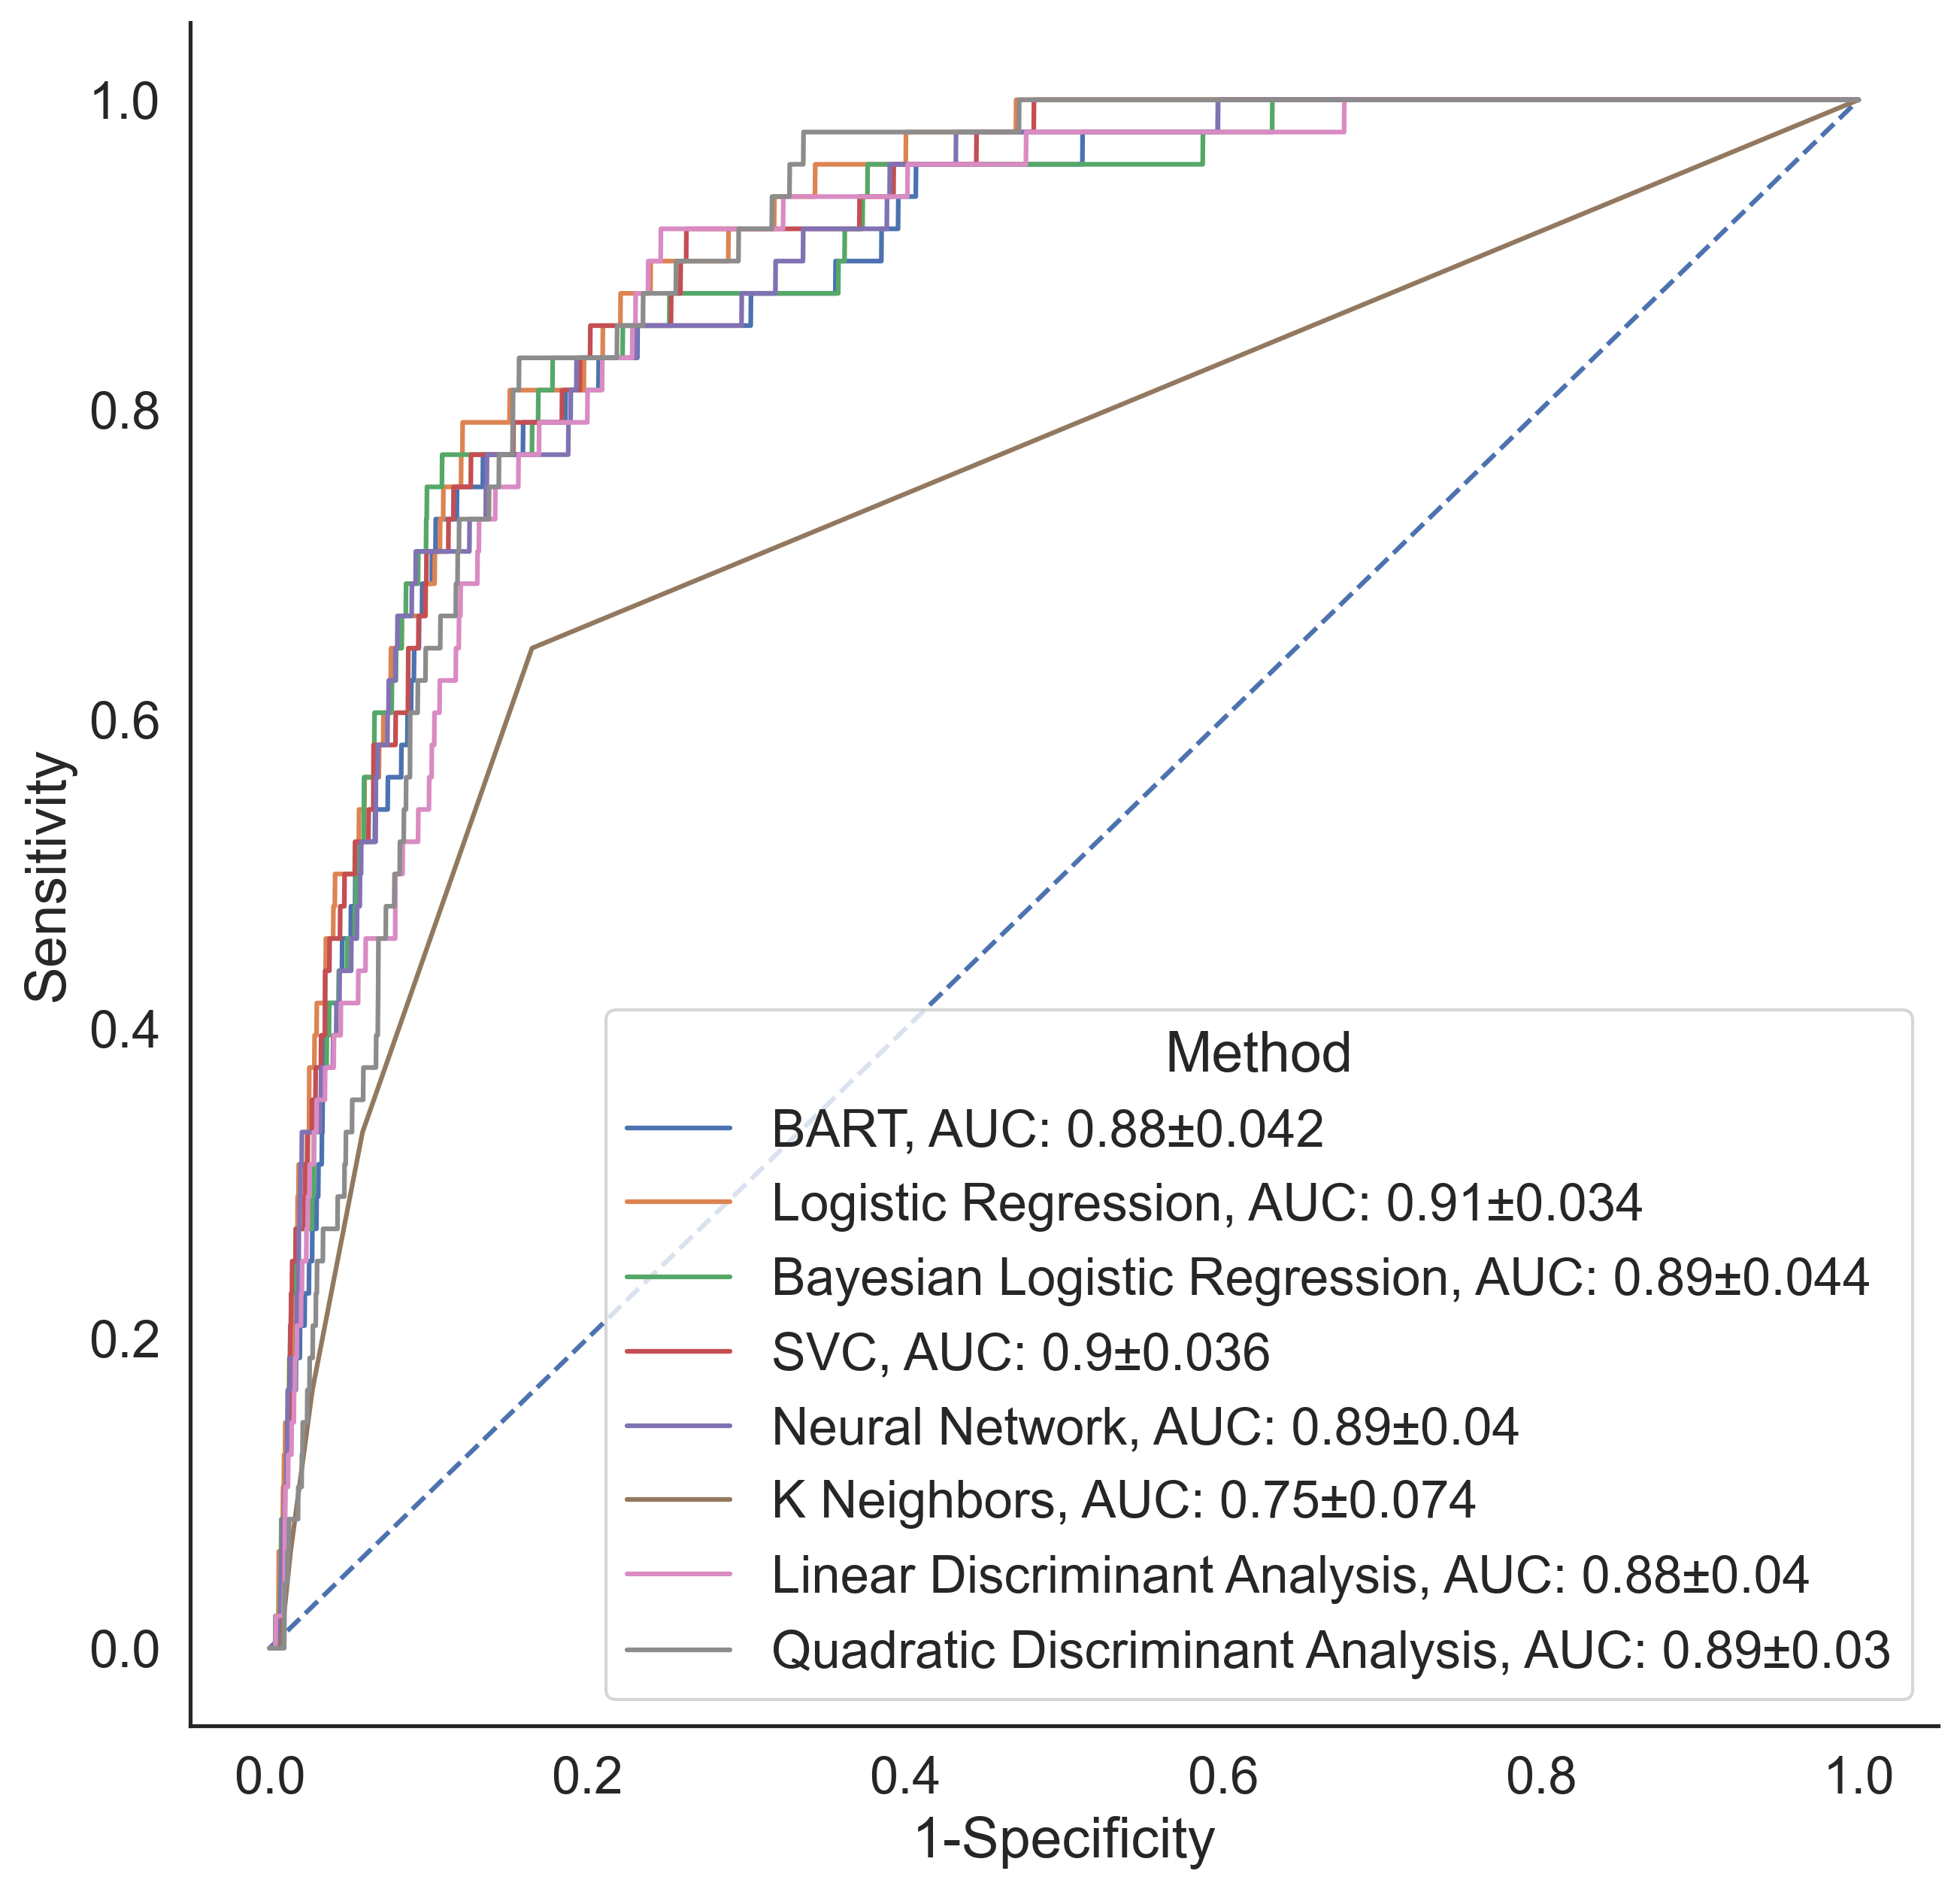

In [287]:
import matplotlib
matplotlib.rcParams['figure.dpi']=400
sns.set(style='white', font_scale=1.5)
np.random.seed(123)

roc_dict={
          'BART, AUC: {}'.format(return_bootstrap_results(results['bart']['results'],auc,1)):results['bart']['roc_df'],
          'Logistic Regression, AUC: {}'.format(return_bootstrap_results(results['lr']['results'],auc,1)):results['lr']['roc_df'],
          'Bayesian Logistic Regression, AUC: {}'.format(return_bootstrap_results(results['blr']['results'],auc,1)):results['blr']['roc_df'],
          'SVC, AUC: {}'.format(return_bootstrap_results(results['svc']['results'],auc,1)):results['svc']['roc_df'],
          'Neural Network, AUC: {}'.format(return_bootstrap_results(results['nn']['results'],auc,1)):results['nn']['roc_df'],
          'K Neighbors, AUC: {}'.format(return_bootstrap_results(results['knn']['results'],auc,1)):results['knn']['roc_df'],
          'Linear Discriminant Analysis, AUC: {}'.format(return_bootstrap_results(results['lda']['results'],auc,1)):results['lda']['roc_df'],
          'Quadratic Discriminant Analysis, AUC: {}'.format(return_bootstrap_results(results['qda']['results'],auc,1)):results['qda']['roc_df'],
} 
plot_rocs(roc_dict)
sns.despine()

# Nonparametric Bootstrapping of Test Set and CV AUCs

In [305]:
import tqdm

bootstrapped_aucs={}
for k in results:
    np.random.seed(42)
    idx=np.arange(len(results['xg']['results'])).astype(int)
    pred=results[k]['results'].iloc[:,[0,-1]]
    aucs=[]
    for i in tqdm.trange(1000):
        idx_new=np.random.choice(idx,len(idx),replace=True)
        pred_new=pred.iloc[idx_new]
        aucs.append(roc_auc_score(*pred_new.values.T.tolist()))
    bootstrapped_aucs[k]=np.array(aucs)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 127.86it/s]


In [548]:
cv_auc_dict={}
for k in cv_results:
    cv_auc_dict[k]=[]
    np.random.seed(42)
    for fold in range(5):
        cv_auc_dict[k].append(roc_auc_score(cv_results[k][fold]['y_val'],cv_results[k][fold]['y_pred']))


In [541]:
cv_auc_bootstrap_dict={}
for k in cv_results:
    cv_auc_bootstrap=[]
    np.random.seed(42)
    idxs=[np.arange(len(cv_results[k][i]['y_val'])).astype(int) for i in range(5)]
    for i in tqdm.trange(1000):
        idxs_new=[np.random.choice(idxs[fold],len(idxs[fold]),replace=True) for fold in range(5)]
        aucs_tmp=[]
        for fold in range(5):
            aucs_tmp.append(roc_auc_score(cv_results[k][fold]['y_val'].iloc[idxs_new[fold]],cv_results[k][fold]['y_pred'][idxs_new[fold]]))
        cv_auc_bootstrap.append(np.mean(aucs_tmp))
    cv_auc_bootstrap_dict[k]=np.array(cv_auc_bootstrap)
    
    
    

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:15<00:00, 66.51it/s]


# CV Results Across Folds and Final Averages with 95% CI

In [558]:
pd.concat([pd.DataFrame(cv_auc_dict).T,pd.DataFrame({k:np.quantile(v,[0.025,0.5,0.975]) for k,v in cv_auc_bootstrap_dict.items()}).T],axis=1)

,0,1,2,3,4,0,1,2
svc,0.921016,0.927512,0.891727,0.857496,0.938346,0.886922,0.907681,0.924806
nn,0.916311,0.933244,0.894160,0.855528,0.938827,0.889730,0.908005,0.925033
knn,0.771517,0.786700,0.773297,0.702108,0.851724,0.743994,0.777946,0.810999
lda,0.894562,0.920447,0.885559,0.845985,0.928837,0.874135,0.895818,0.913166
qda,0.865296,0.874820,0.862614,0.875682,0.912151,0.851973,0.878705,0.900174
lr,0.907953,0.917067,0.892731,0.858048,0.935814,0.881971,0.902915,0.919607
nb,0.860681,0.917132,0.880196,0.849523,0.921256,0.864556,0.886324,0.905758
dt,0.737115,0.783344,0.767718,0.712494,0.777913,0.736596,0.756542,0.774078
rf,0.896381,0.936123,0.895808,0.841807,0.926263,0.878593,0.899922,0.918944
xg,0.898649,0.926911,0.886345,0.849638,0.933460,0.880296,0.899127,0.917566


# Test Set 95% CI

In [835]:
pd.concat([pd.DataFrame({k:np.quantile(v,[0.5,0.025,0.975]) for k,v in bootstrapped_aucs.items()}).T],axis=1)

,0,1,2
svc,0.899452,0.860265,0.929901
nn,0.890105,0.848793,0.924575
knn,0.750720,0.676019,0.816482
lda,0.884372,0.839300,0.917000
qda,0.891296,0.857343,0.916772
lr,0.907055,0.869431,0.934614
nb,0.865701,0.828666,0.897776
dt,0.758902,0.716284,0.792318
rf,0.896915,0.857940,0.926435
xg,0.887943,0.845535,0.924111


# Pairwise AUC differences between models for CV and Test Set

In [833]:
df_res=pd.DataFrame([np.hstack([(k1,k2),np.quantile(bootstrapped_aucs[k1]-bootstrapped_aucs[k2],[0.5,0.025,0.975])]) for k1,k2 in [x.split("-") for x in set(["-".join(sorted([k1,k2])) for k1 in results for k2 in results if k1!=k2])]],columns=['algo1','algo2','Estimate','2.5%CI','97.5%CI'])
df_res.iloc[:,-3:]=df_res.iloc[:,-3:].astype(float)
df_res['Reject H0']=df_res.iloc[:,-2:].apply(lambda x: len(np.where(np.logical_and(0<=x.values[1], 0>=x.values[0]))[0])==0,axis=1)
df_res.to_csv("test_auc_res.csv")


In [832]:
df_res_cv=pd.DataFrame([np.hstack([(k1,k2),np.quantile(cv_auc_bootstrap_dict[k1]-cv_auc_bootstrap_dict[k2],[0.5,0.025,0.975])]) for k1,k2 in [x.split("-") for x in set(["-".join(sorted([k1,k2])) for k1 in cv_results for k2 in cv_results if k1!=k2])]],columns=['algo1','algo2','Estimate','2.5%CI','97.5%CI'])
df_res_cv.iloc[:,-3:]=df_res_cv.iloc[:,-3:].astype(float)
df_res_cv['Reject H0']=df_res_cv.iloc[:,-2:].apply(lambda x: len(np.where(np.logical_and(0<=x.values[1], 0>=x.values[0]))[0])==0,axis=1)
df_res_cv.to_csv("cv_auc_res.csv")

# Bootstrapping SHAP interpretation methods

In [827]:
explainer_rf,shap_values_rf=run_shap(X_train, X_test, results['rf']['best_estimator'], model_type='tree', explainer_options={}, get_shap_values_options=dict(approximate=True))
explainer_xg,shap_values_xg=run_shap(X_train, X_test, results['xg']['best_estimator'], model_type='tree', get_shap_values_options=dict(approximate=True))
explainer_lr,shap_values_lr=run_shap(X_train, X_test, results['lr']['best_estimator'], model_type='linear', explainer_options={}, get_shap_values_options=dict())


In [562]:
shap_values=dict(lr=shap_values_lr,
                rf=shap_values_rf,
                xg=shap_values_xg)

In [610]:
def calc_global_importance(shap_values):
    return np.abs(shap_values).sum(0)#(-np.abs(shap_values).sum(0)).argsort()

bootstrapped_importances={}
idx=np.arange(len(shap_values['lr'])).astype(int)
for k in shap_values:
    np.random.seed(42)
    bootstrapped_importances[k]=[]
    for i in tqdm.trange(1000):
        bootstrapped_importances[k].append(calc_global_importance(shap_values[k][np.random.choice(idx,len(idx),replace=True)]))    
bootstrapped_importances=pd.DataFrame(bootstrapped_importances)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 942.14it/s]


# Comparing SHAP global importances with spearman and RBO

In [750]:
import rbo
test_features=np.arange(len(X_test.columns)).astype(int)

rbo_lr_rf=pd.DataFrame(bootstrapped_importances[['lr','rf']].applymap(lambda x: test_features[(-x).argsort()]).apply(lambda x: rbo.RankingSimilarity(*x.tolist()).rbo_ext(p=0.9),axis=1),columns=['r'])
rbo_lr_xg=pd.DataFrame(bootstrapped_importances[['lr','xg']].applymap(lambda x: test_features[(-x).argsort()]).apply(lambda x: rbo.RankingSimilarity(*x.tolist()).rbo_ext(p=0.9),axis=1),columns=['r'])
rbo_rf_xg=pd.DataFrame(bootstrapped_importances[['rf','xg']].applymap(lambda x: test_features[(-x).argsort()]).apply(lambda x: rbo.RankingSimilarity(*x.tolist()).rbo_ext(p=0.9),axis=1),columns=['r'])


In [751]:
from scipy.stats import pearsonr, spearmanr, kendalltau

spearmanr_lr_rf=pd.DataFrame(bootstrapped_importances[['lr','rf']].apply(lambda x: spearmanr(*x.tolist()),axis=1).tolist(),columns=['r','p'])
spearmanr_lr_xg=pd.DataFrame(bootstrapped_importances[['lr','xg']].apply(lambda x: spearmanr(*x.tolist()),axis=1).tolist(),columns=['r','p'])
spearmanr_rf_xg=pd.DataFrame(bootstrapped_importances[['rf','xg']].apply(lambda x: spearmanr(*x.tolist()),axis=1).tolist(),columns=['r','p'])




In [752]:
pd.concat([
           spearmanr_lr_rf['r'],
           spearmanr_lr_xg['r'],
           spearmanr_rf_xg['r'],
           spearmanr_rf_xg['r']-spearmanr_lr_rf['r'],
           spearmanr_rf_xg['r']-spearmanr_lr_xg['r'],
           spearmanr_lr_xg['r']-spearmanr_lr_rf['r'],
           rbo_lr_rf['r'],
           rbo_lr_xg['r'],
           rbo_rf_xg['r'],
           rbo_rf_xg['r']-rbo_lr_rf['r'],
           rbo_rf_xg['r']-rbo_lr_xg['r'],
           rbo_lr_xg['r']-rbo_lr_rf['r']],axis=1).apply(lambda x:np.quantile(x,[0.5,0.025,0.975]).tolist(),axis=0).T




,0,1,2
r,0.706087,0.690435,0.713043
r,0.731592,0.724163,0.747278
r,0.759915,0.747714,0.772115
r,0.054688,0.039867,0.069507
r,0.023965,0.011765,0.037473
r,0.028114,0.015921,0.050743
r,0.682958,0.679083,0.682958
r,0.637664,0.636738,0.644651
r,0.669883,0.666009,0.672498
r,-0.013074,-0.016949,-0.009200


# Comparing SHAP with LIME

In [828]:
class helper_object():
    """
    This wraps the shap object.
    It takes as input i, which indicates the index of the observation to be explained.
    """
    def __init__(self, i, X, shap_values, explainer):
        self.base_values = explainer.expected_value[1]
        self.data = X.iloc[i]
        self.feature_names = X.columns.to_list()
        self.values = shap_values[i]
        
class helper_object_xg():
    """
    This wraps the shap object.
    It takes as input i, which indicates the index of the observation to be explained.
    """
    def __init__(self, i, X, shap_values, explainer):
        self.base_values = (explainer.expected_value)#(lambda x: 1/(1+np.exp(-x)))
        self.data = X.iloc[i]
        self.feature_names = X.columns.to_list()
        self.values = (shap_values[i])#(lambda x: 1/(1+np.exp(-x)))


In [785]:
import lime
import lime.lime_tabular
from lime.explanation import Explanation

class Explanation2(object):
    
    def __init__(self,explainer,*args,**kwargs):
        self.explainer=explainer
        self.mode=self.explainer.mode
        self.class_names=self.explainer.class_names
    
    def as_pyplot_figure(self, label=1, figsize=(4,4), **kwargs):
        """Returns the explanation as a pyplot figure.
        Will throw an error if you don't have matplotlib installed
        Args:
            label: desired label. If you ask for a label for which an
                   explanation wasn't computed, will throw an exception.
                   Will be ignored for regression explanations.
            figsize: desired size of pyplot in tuple format, defaults to (4,4).
            kwargs: keyword arguments, passed to domain_mapper
        Returns:
            pyplot figure (barchart).
        """
        import matplotlib.pyplot as plt
        exp = self.explainer.as_list(label=label, **kwargs)
        fig = plt.figure(figsize=figsize)
        vals = [x[1] for x in exp]
        names = [x[0] for x in exp]
        vals.reverse()
        names.reverse()
        colors = ['red' if x > 0 else 'blue' for x in vals]
        pos = np.arange(len(exp)) + .5
        plt.barh(pos, vals, align='center', color=colors)
        plt.yticks(pos, names)
        if self.mode == "classification":
            title = 'Local explanation for class %s' % self.class_names[label]
        else:
            title = 'Local explanation'
        plt.title(title)
        return fig

explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, mode="classification",feature_names=X_train.columns)

Text(0.5, 1.0, 'HAPI Prediction: 0.46')

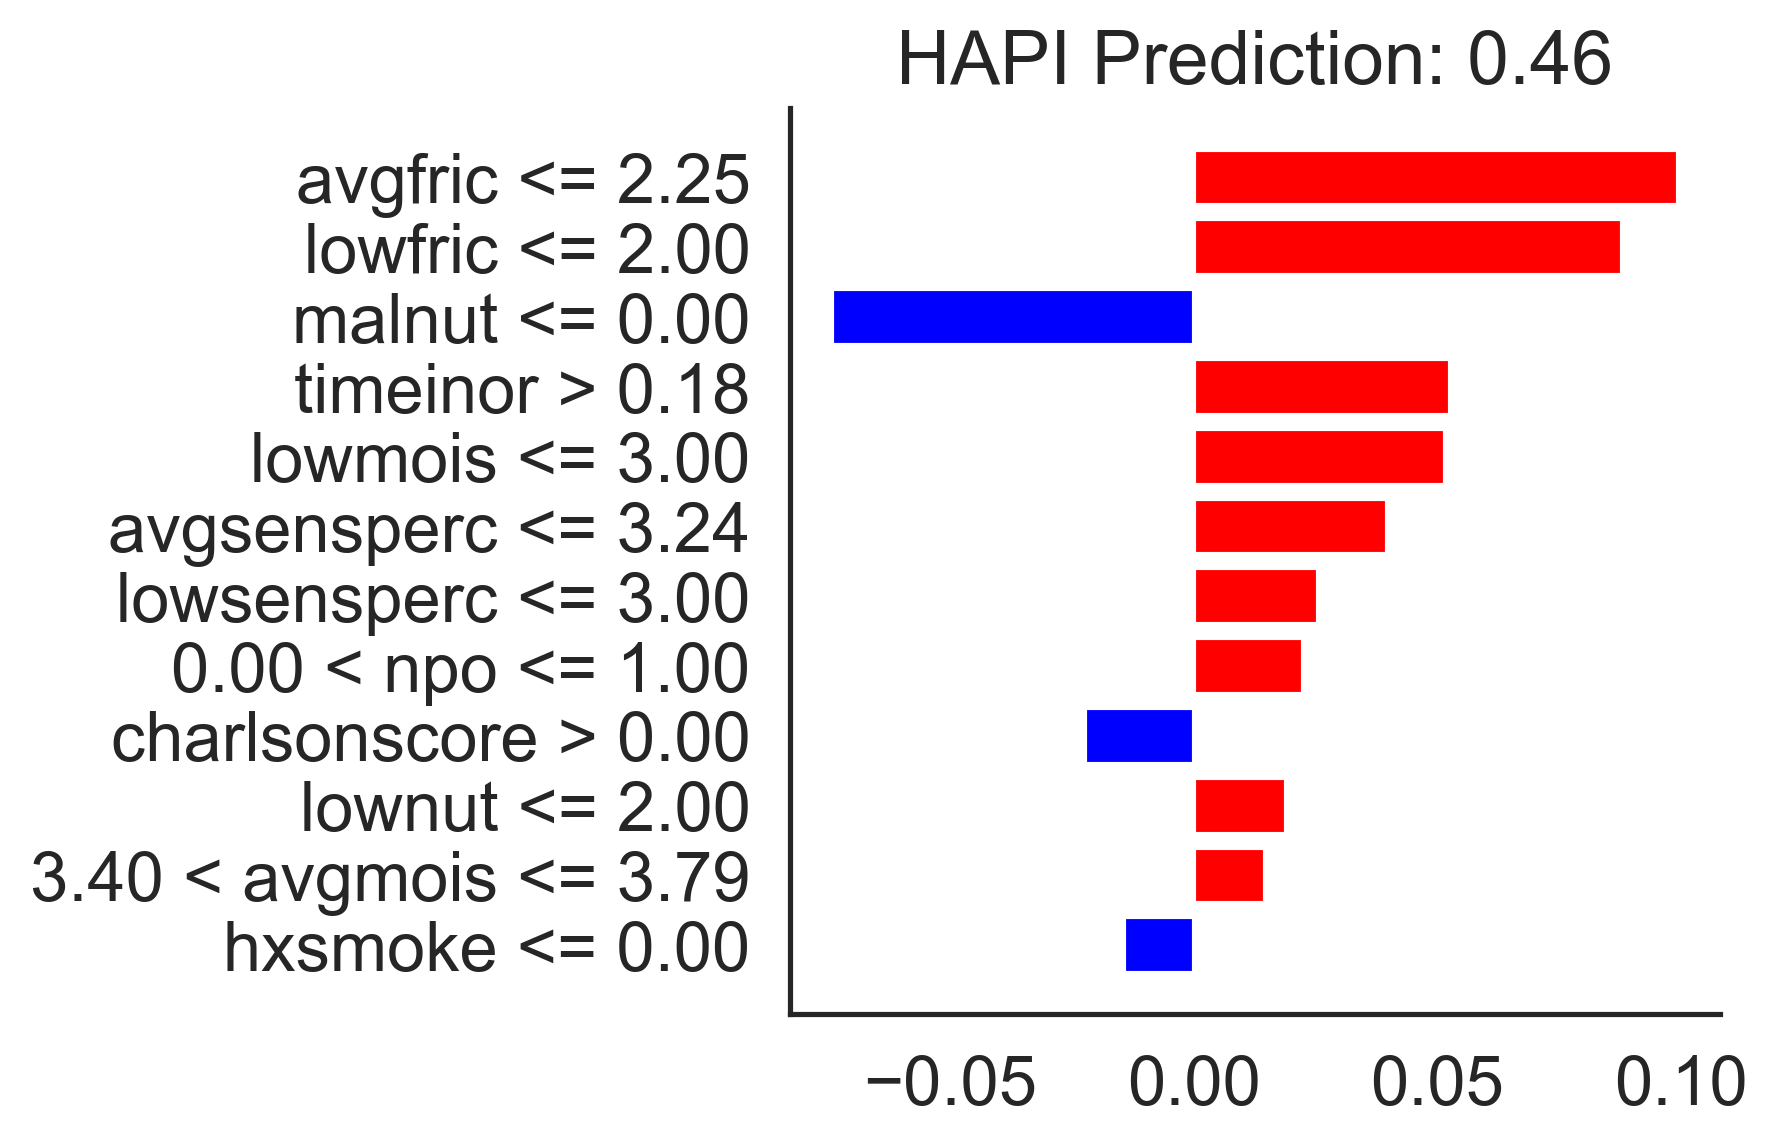

In [830]:
explanation=Explanation2(explainer.explain_instance(X_test[y_test==1].values[0], results['rf']['best_estimator'].predict_proba, labels=[1], num_features=X_test.shape[1]//2))
explanation.as_pyplot_figure()
sns.despine()
plt.title(f"HAPI Prediction: {round(results['rf']['results'].values[y_test==1][0,-1],2)}")


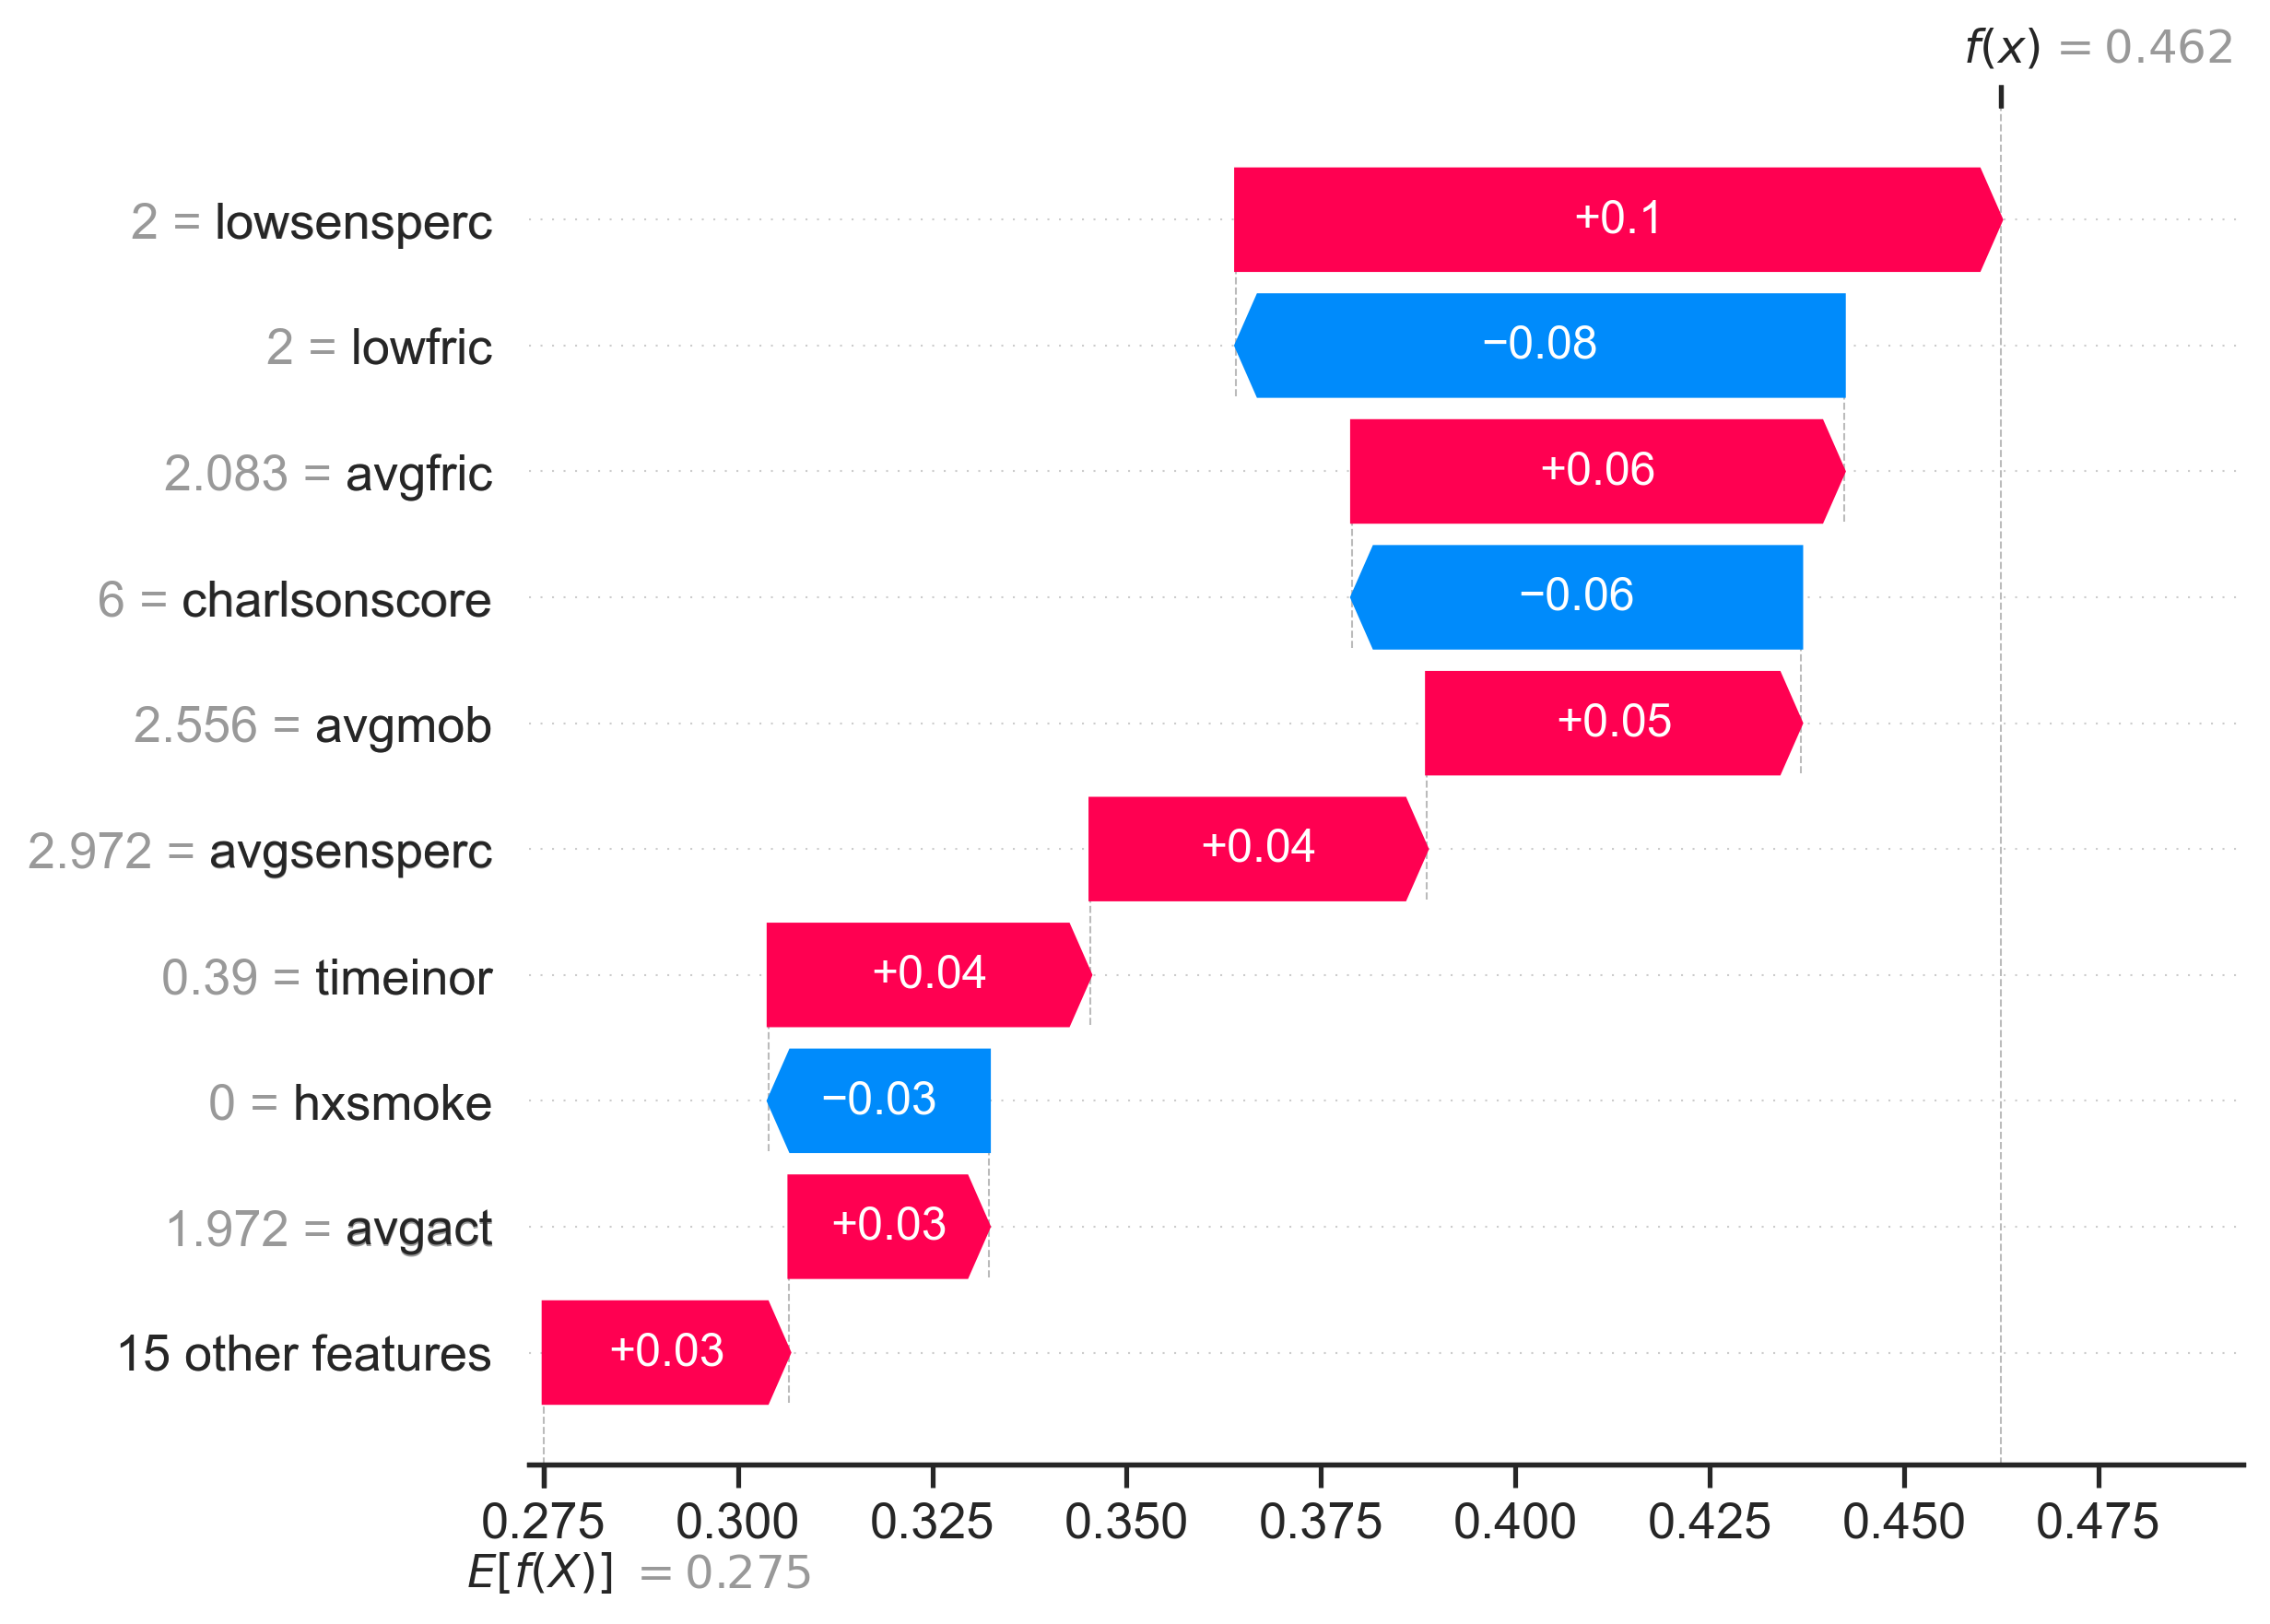

In [374]:
shap.plots.waterfall(helper_object(np.where(y_test==1)[0][0],X_test,shap_values_rf,explainer_rf))#expected, shap_values[i, :], X_test.values[i, :])

Text(0.5, 1.0, 'HAPI Prediction: 0.0')

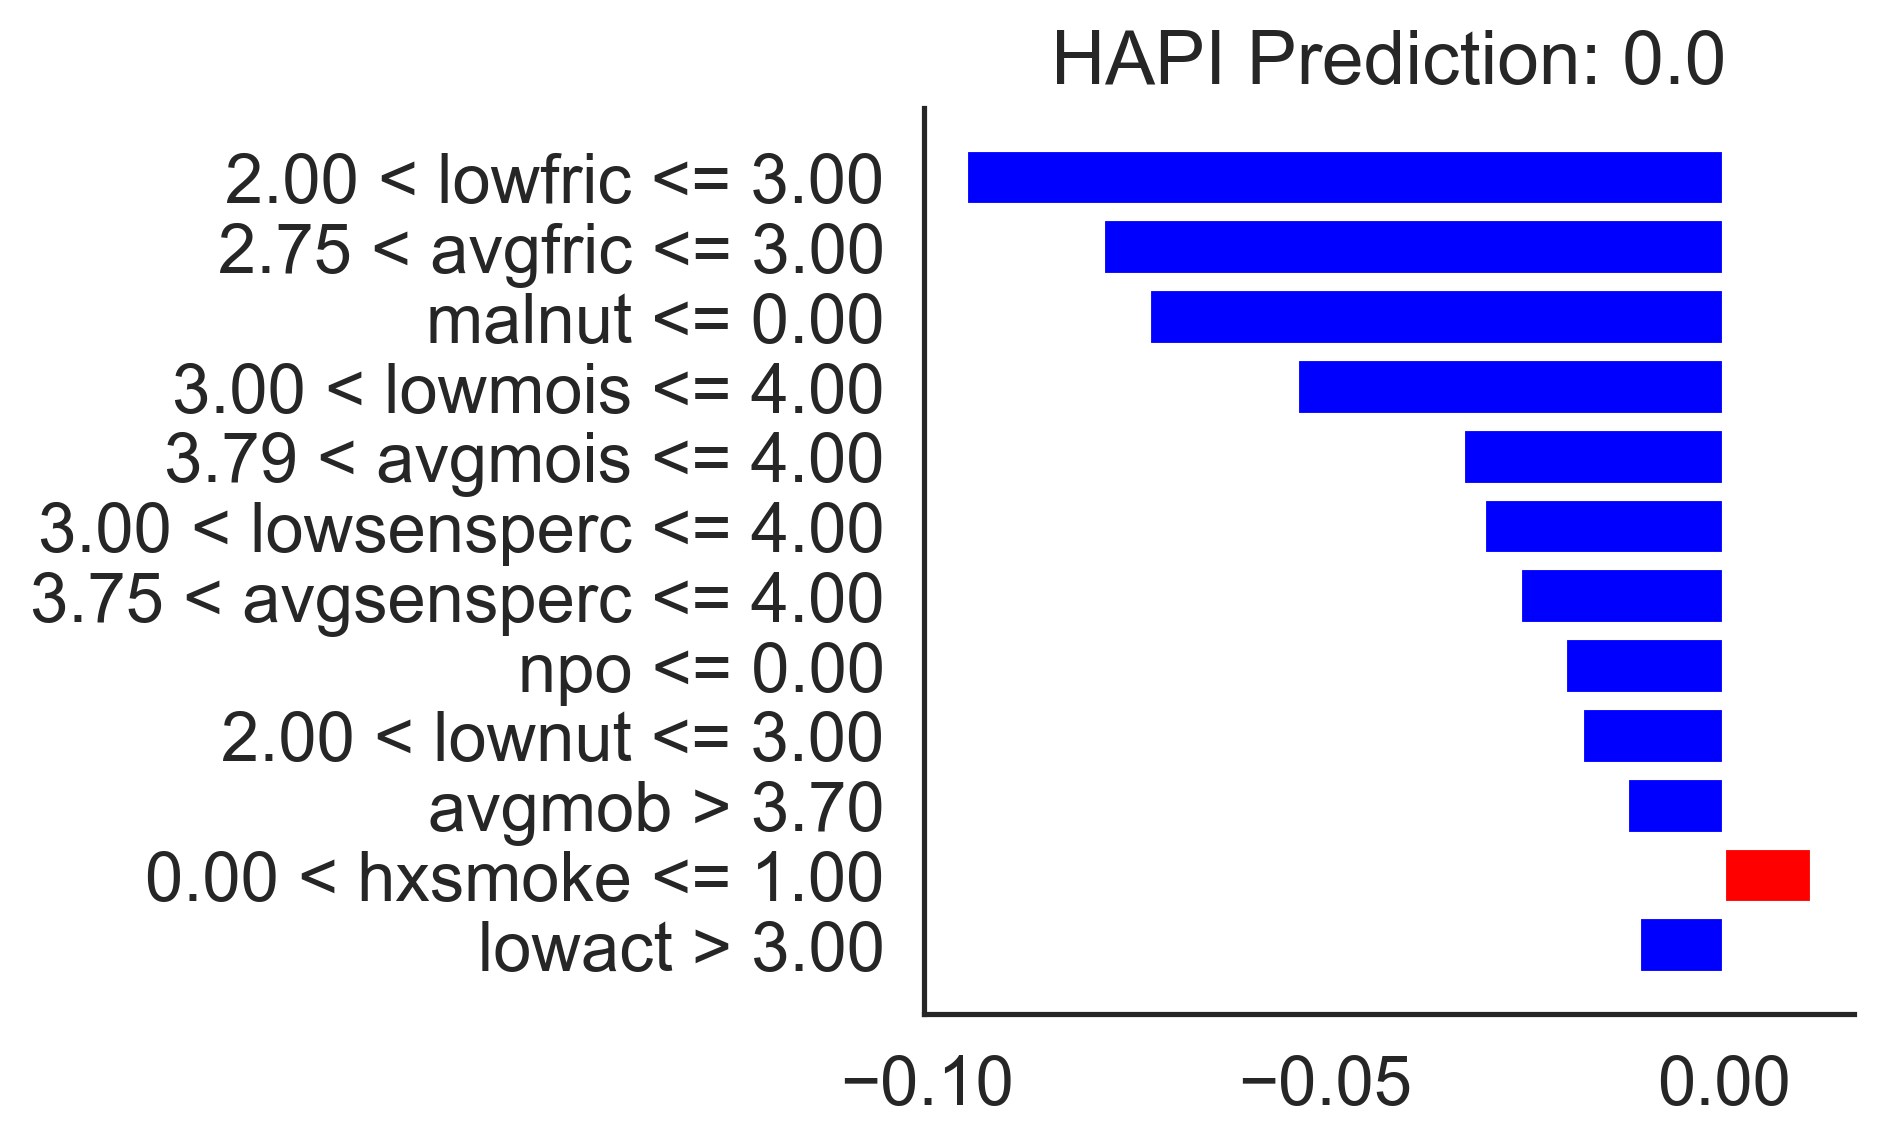

In [807]:
explanation=Explanation2(explainer.explain_instance(X_test[y_test==0].values[0], results['rf']['best_estimator'].predict_proba, labels=[1], num_features=X_test.shape[1]//2))
# explanation.show_in_notebook(show_table=True, show_all=False)
explanation.as_pyplot_figure()
sns.despine()
plt.title(f"HAPI Prediction: {round(results['rf']['results'].values[y_test==0][0,-1],2)}")


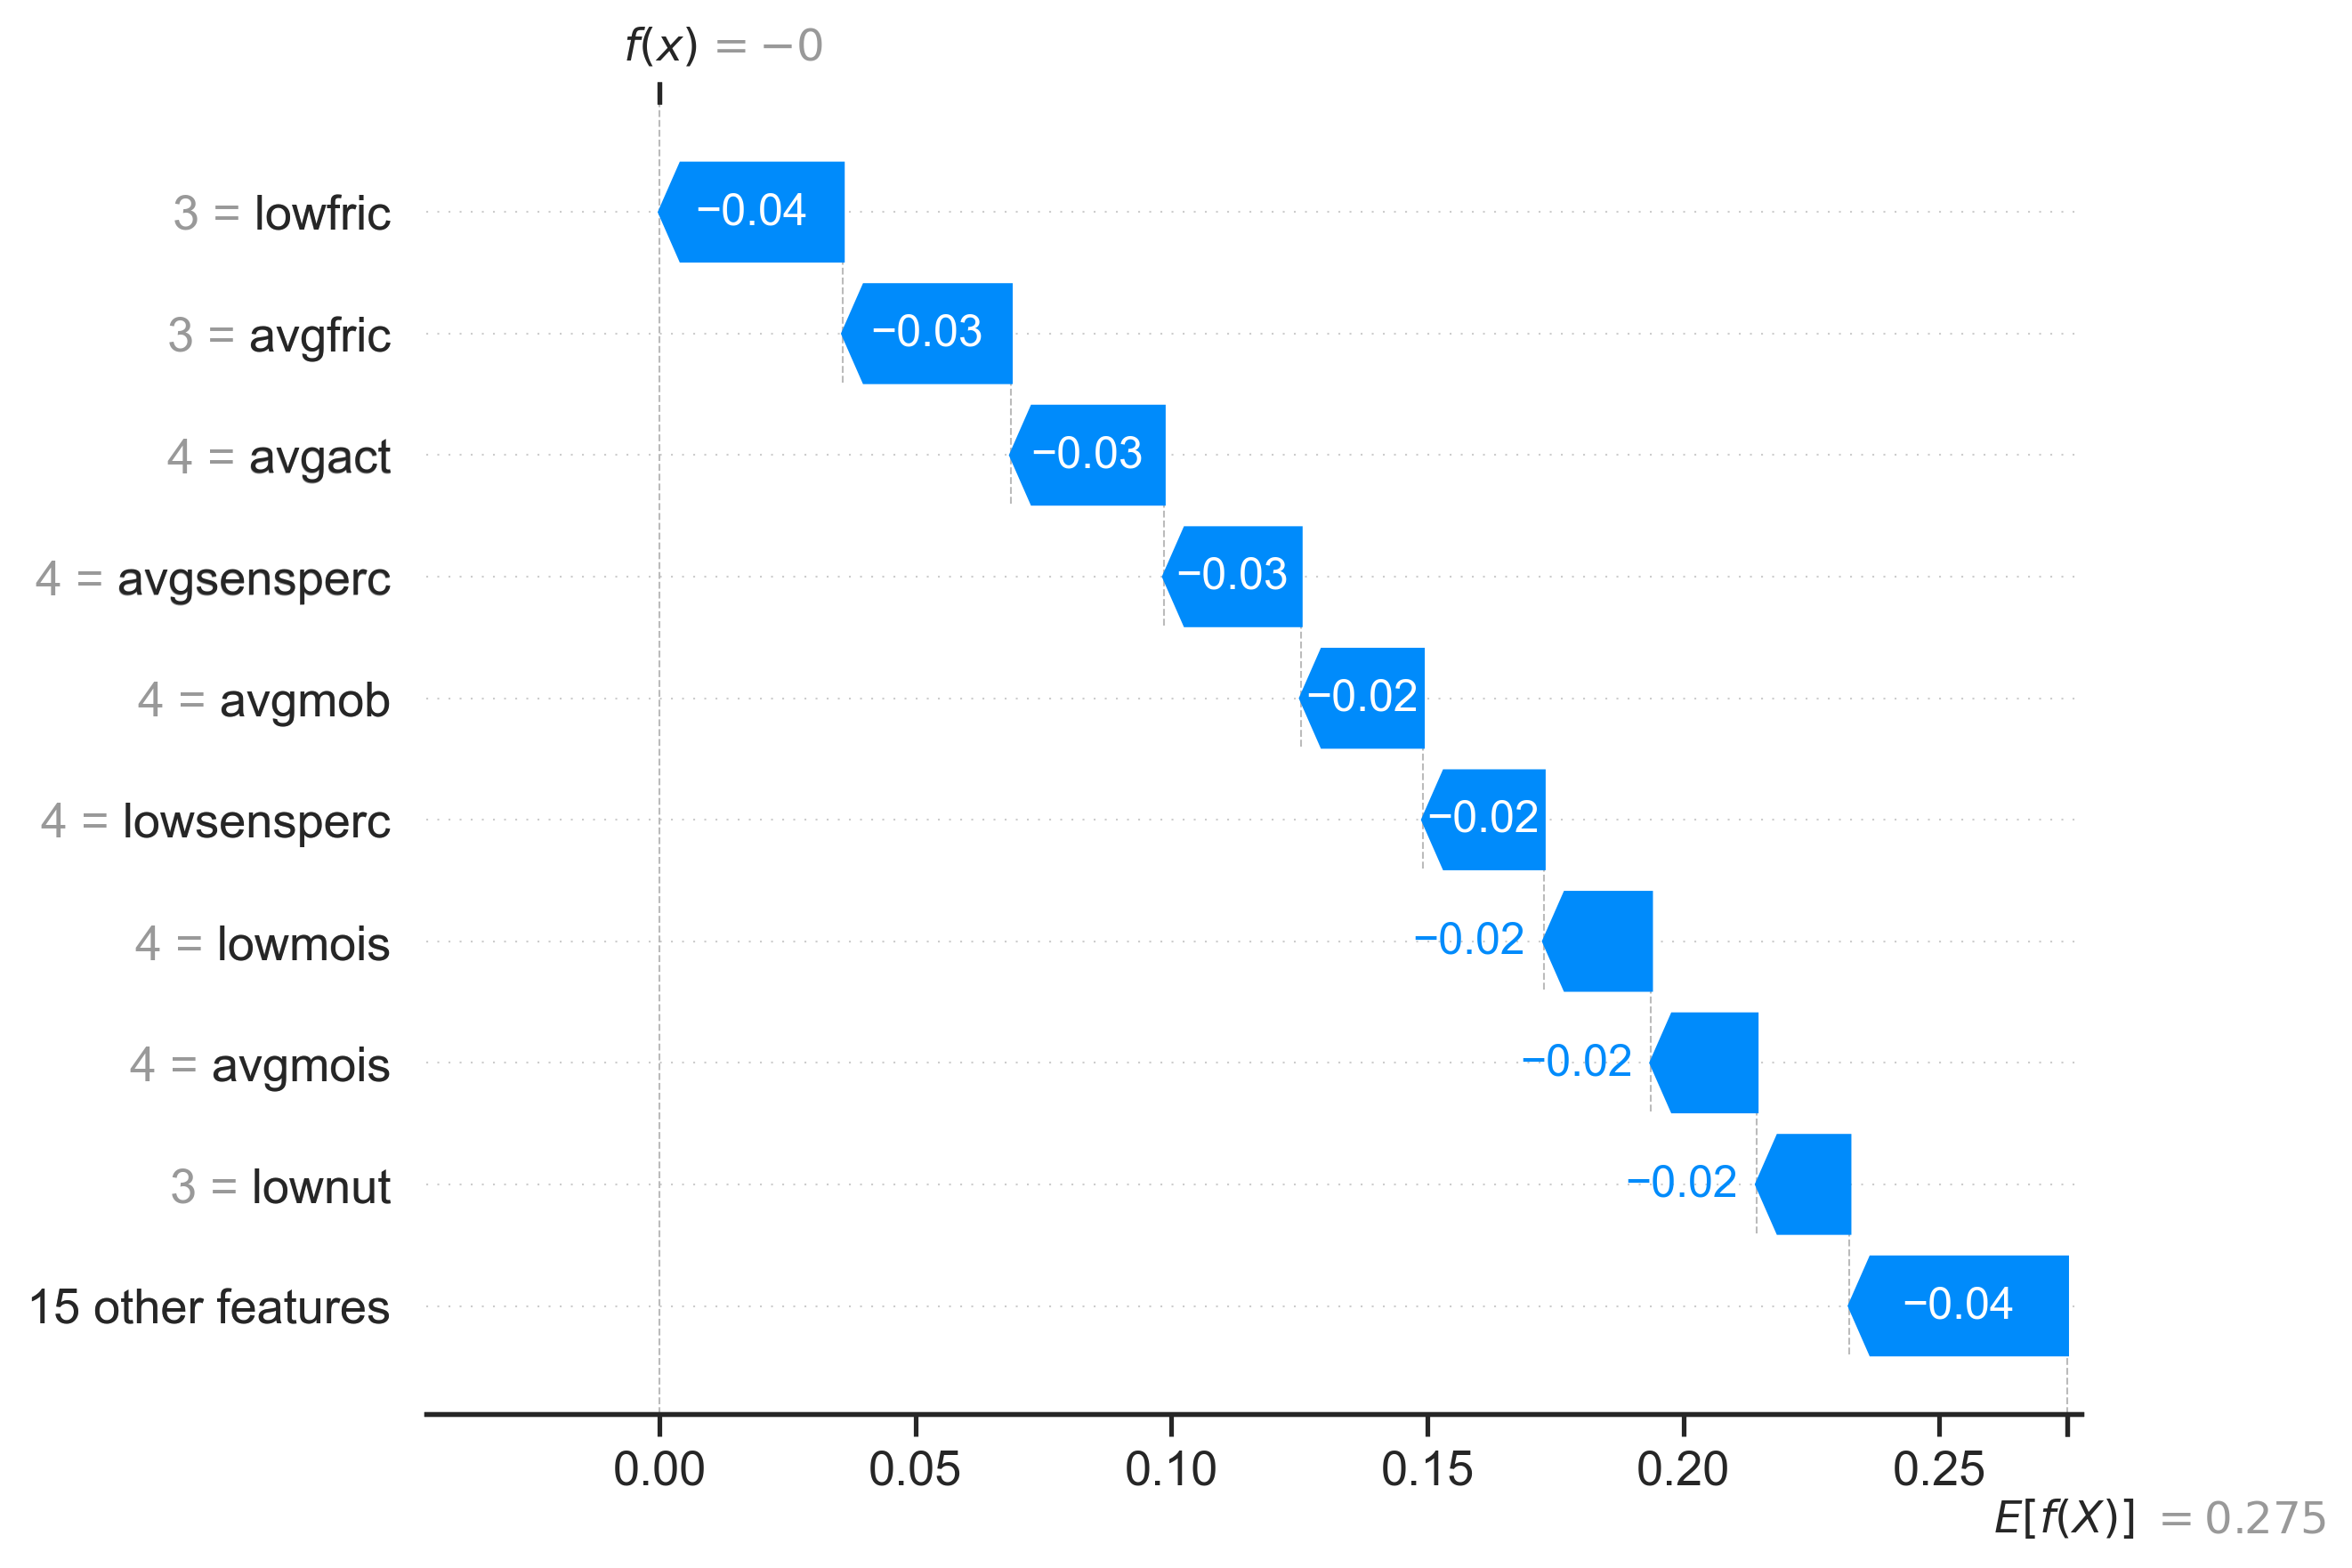

In [480]:
shap.plots.waterfall(helper_object(np.where(y_test==0)[0][0],X_test,shap_values_rf,explainer_rf))#expected, shap_values[i, :], X_test.values[i, :])



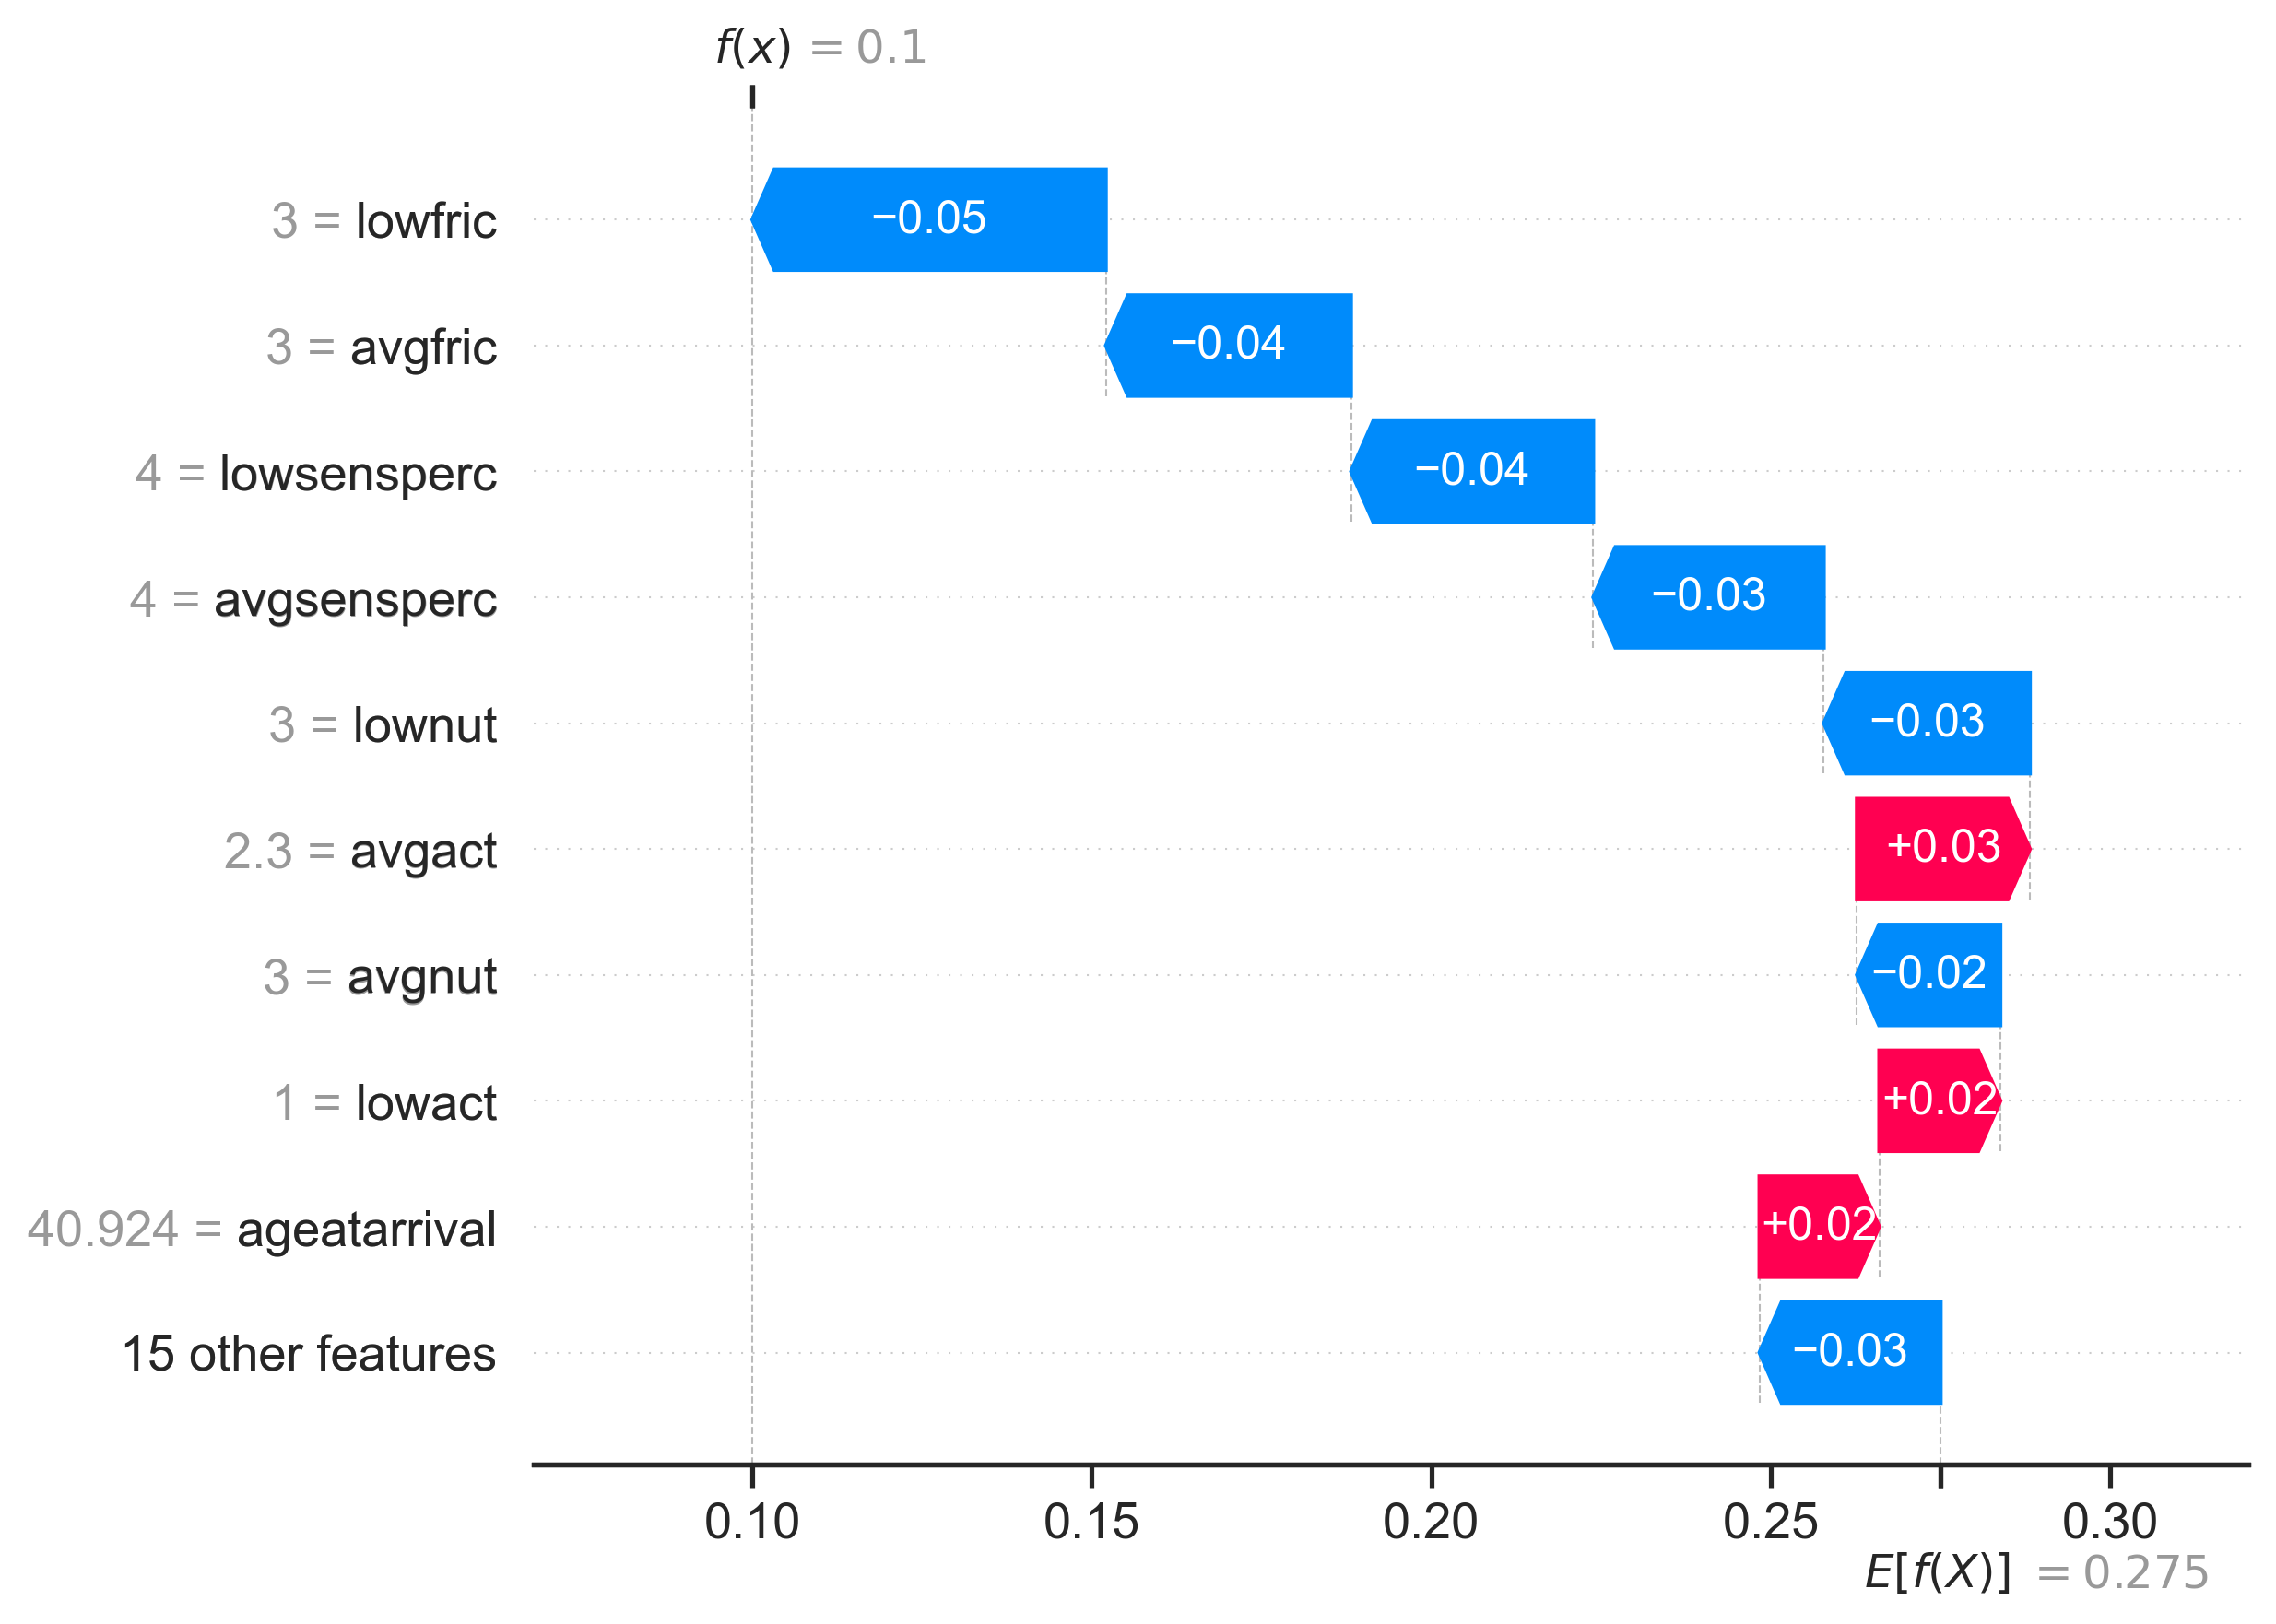

In [481]:
shap.plots.waterfall(helper_object(np.where(y_test==0)[0][15],X_test,shap_values_rf,explainer_rf))#expected, shap_values[i, :], X_test.values[i, :])


Text(0.5, 1.0, 'HAPI Prediction: 0.62')

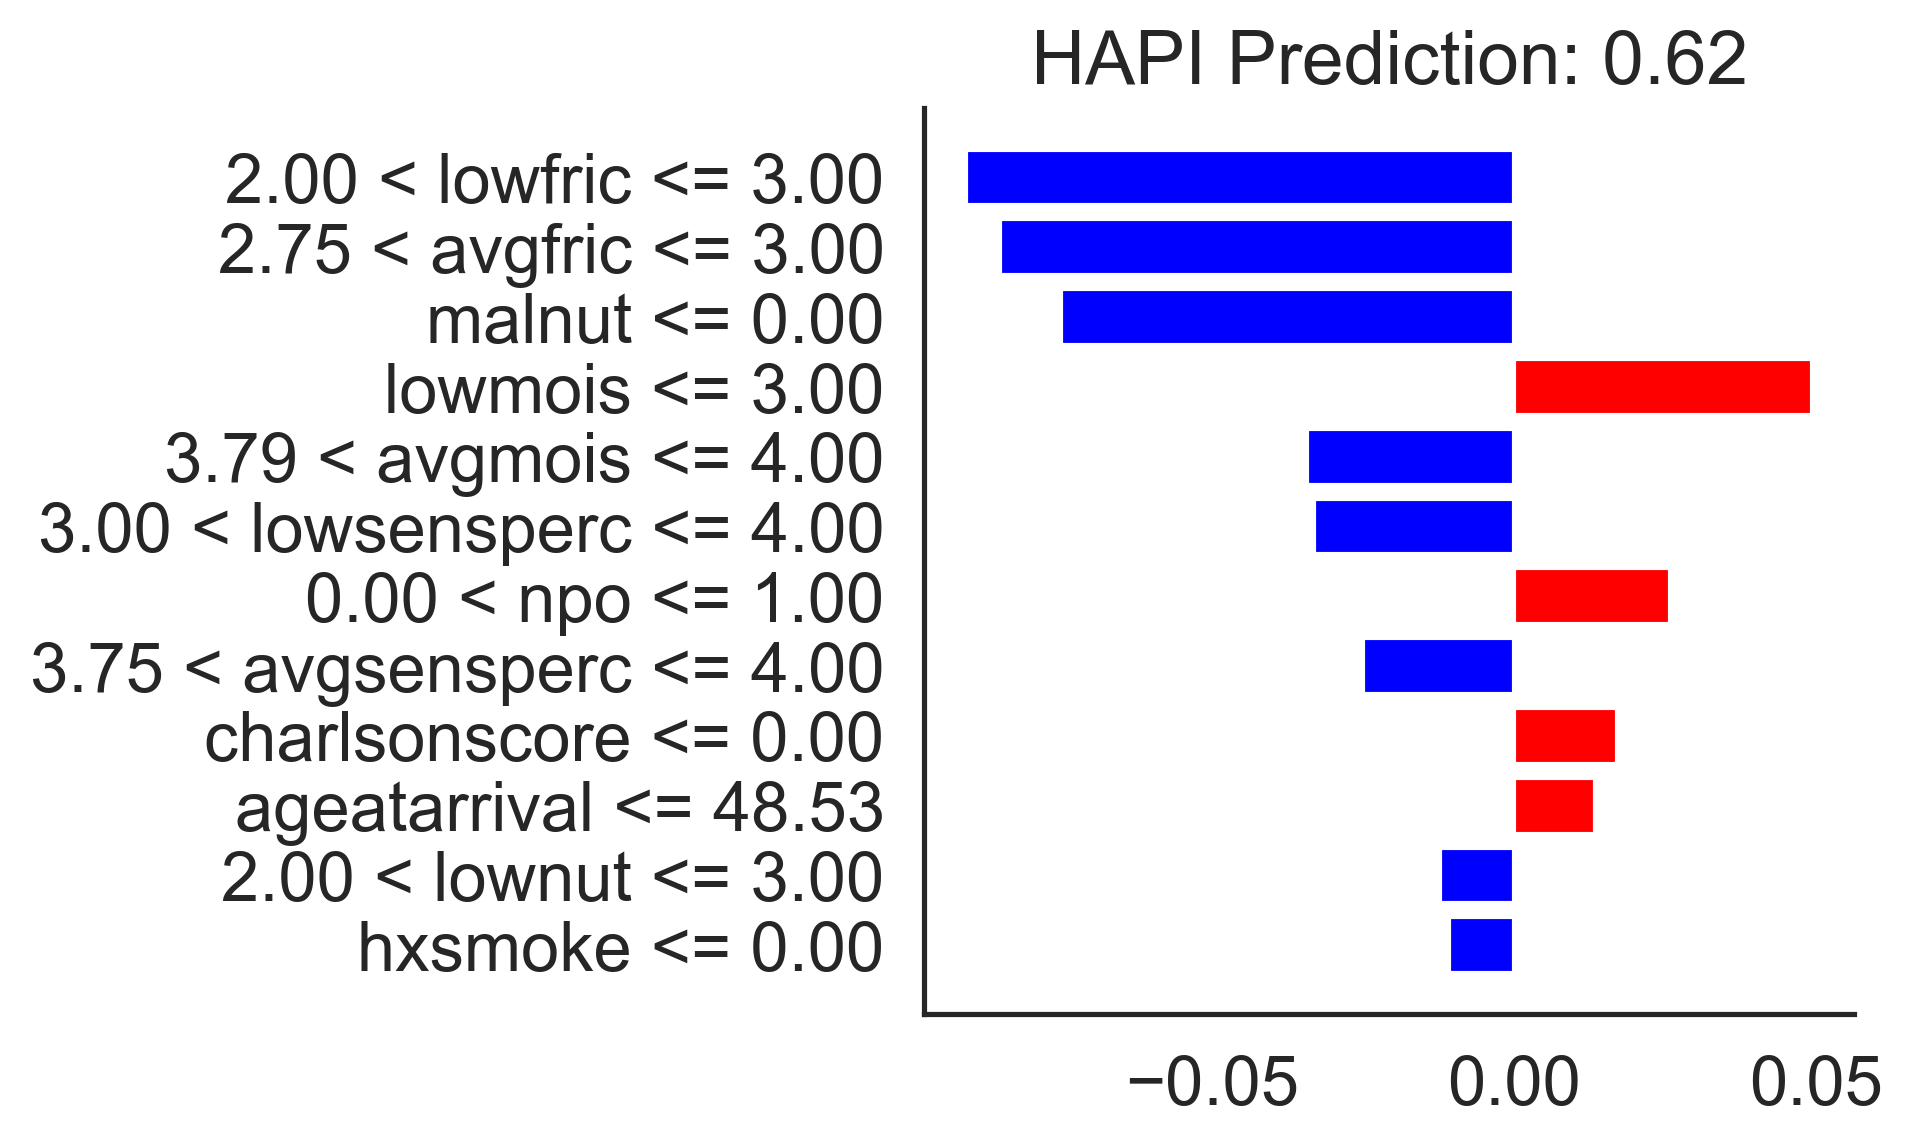

In [806]:
explanation=Explanation2(explainer.explain_instance(X_test[y_test==0].values[15], results['rf']['best_estimator'].predict_proba, labels=[1], num_features=X_test.shape[1]//2))
explanation.as_pyplot_figure()
sns.despine()
plt.title(f"HAPI Prediction: {round(results['rf']['results'].values[y_test==1][15,-1],2)}")


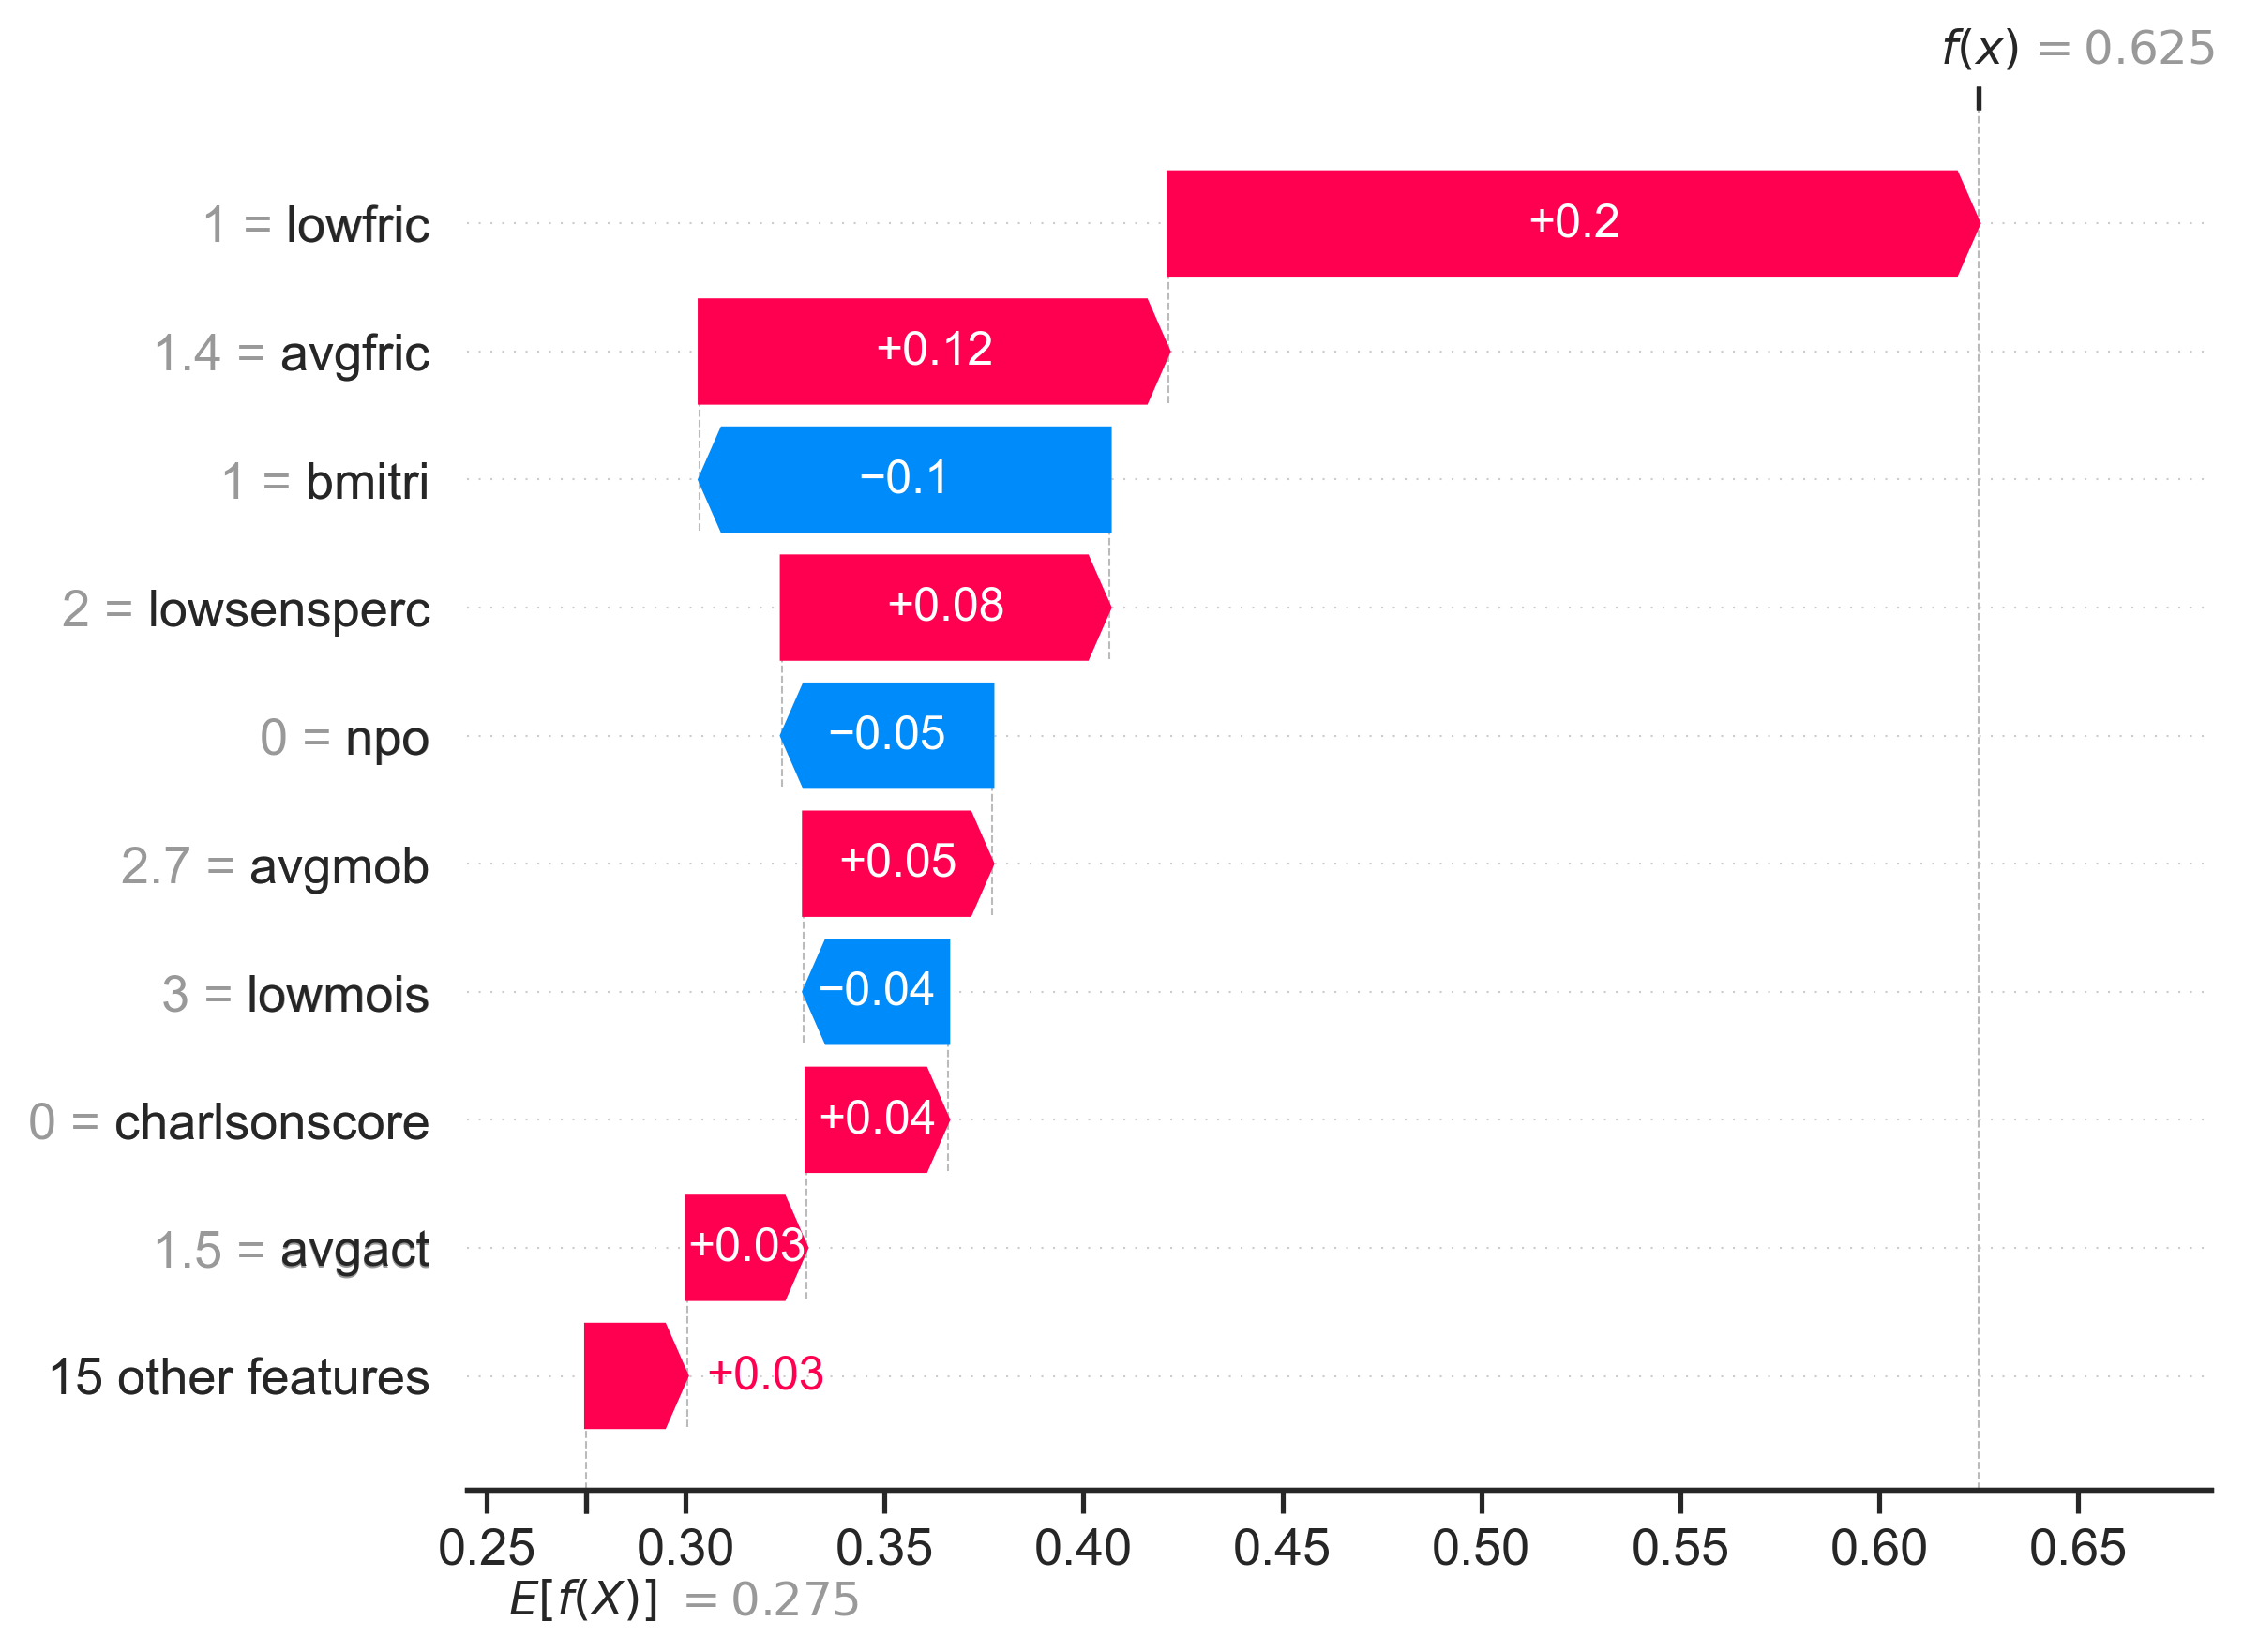

In [770]:
matplotlib.rcParams['figure.dpi']=300
shap.plots.waterfall(helper_object(np.where(y_test==1)[0][15],X_test,shap_values_rf,explainer_rf))#expected, shap_values[i, :], X_test.values[i, :])


Text(0.5, 1.0, 'HAPI Prediction: 0.66')

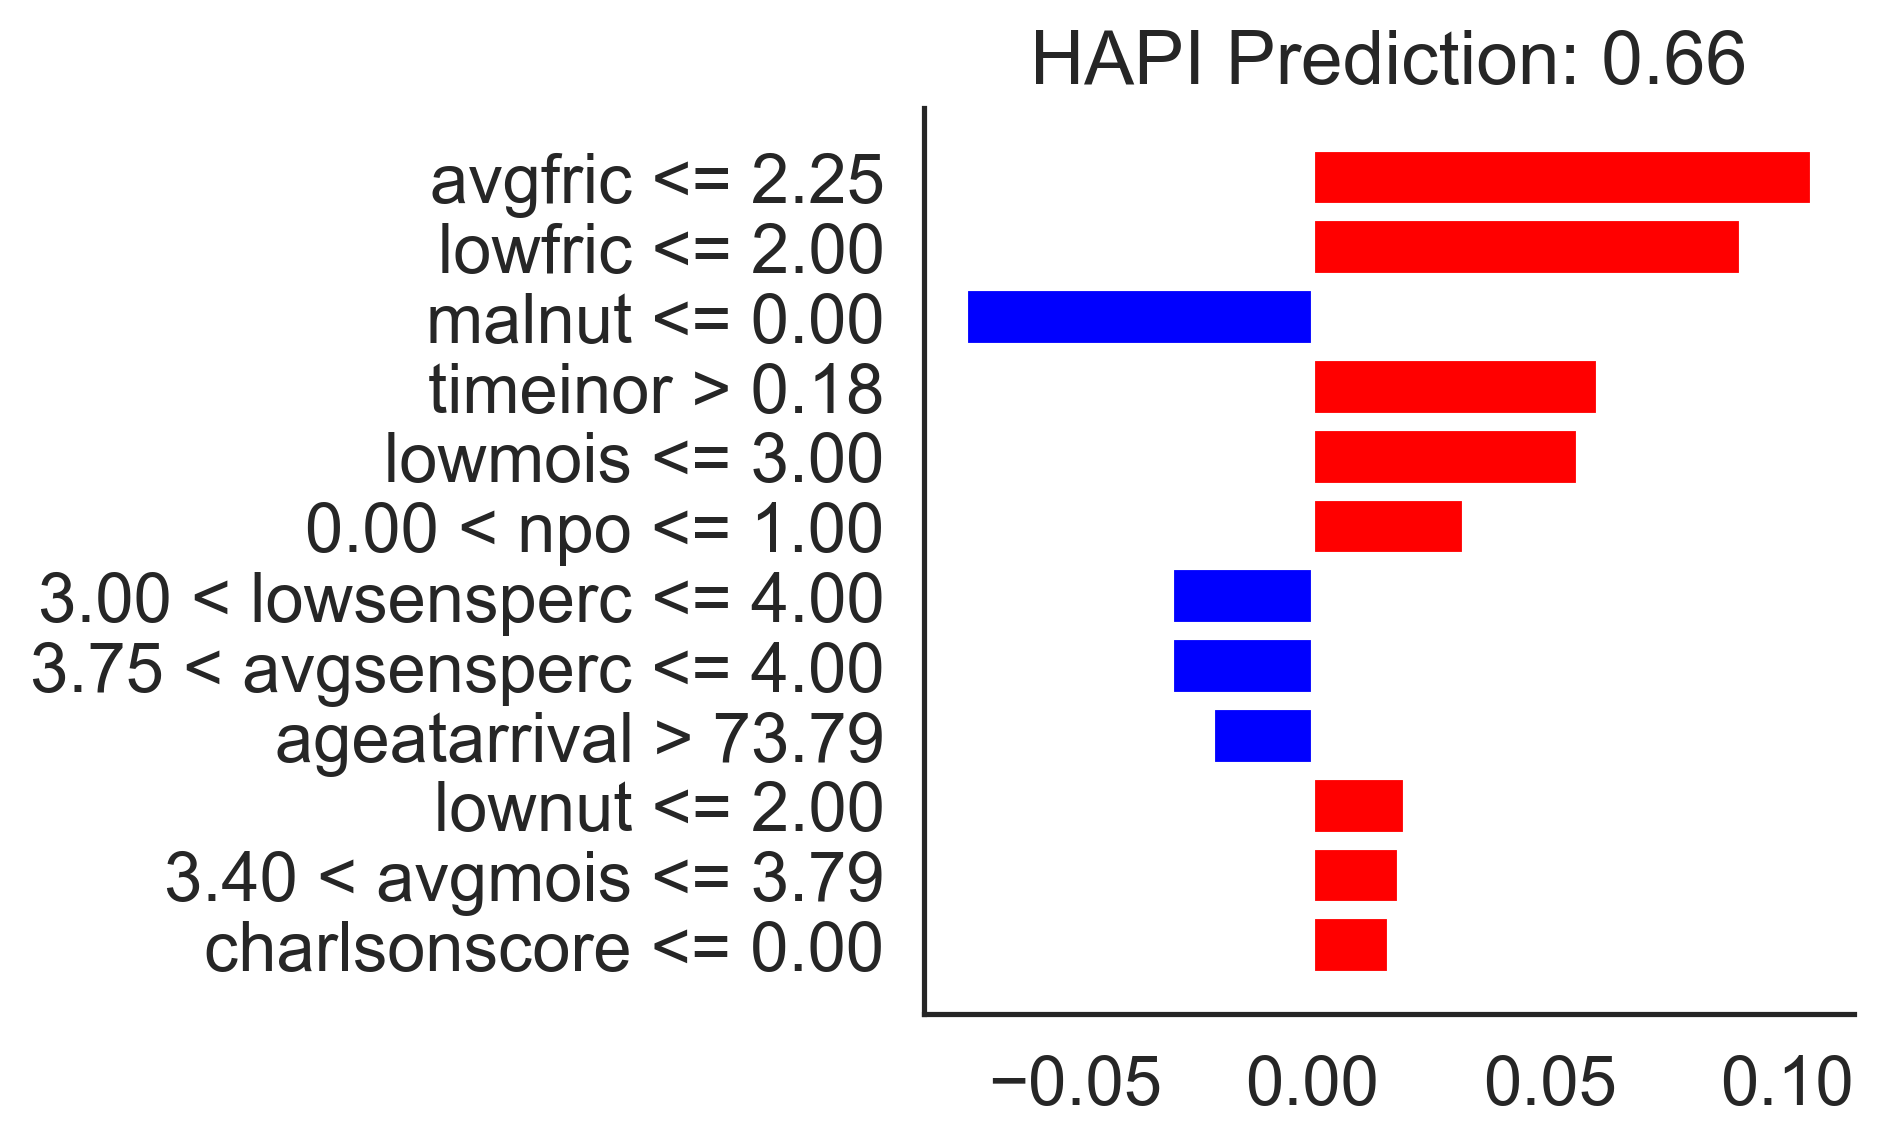

In [805]:
explanation=Explanation2(explainer.explain_instance(X_test[y_test==1].values[25], results['rf']['best_estimator'].predict_proba, labels=[1], num_features=X_test.shape[1]//2))
explanation.as_pyplot_figure()
sns.despine()
plt.title(f"HAPI Prediction: {round(results['rf']['results'].values[y_test==1][25,-1],2)}")
